### installations

In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install moviepy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# University of Aberdeen

## Applied AI (CS5079)

### 4x4

In [7]:
# # delete video folder
# import shutil
# folder_path = "./video"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

Progress: 100%|█████████████████████████████| 5000/5000 [02:57<00:00, 28.13it/s]


Training completed.


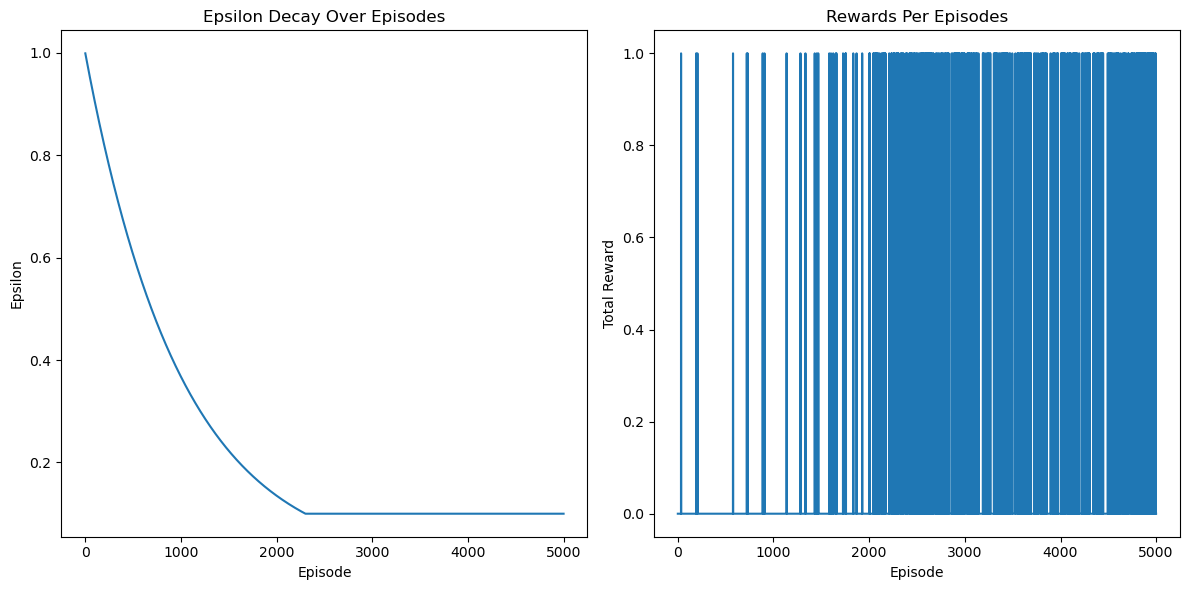

In [10]:
# importing libraries for environments, display and plotting
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# generating map
random_map = generate_random_map(size=4, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# video capture
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: (x+1) % 10 == 0)

state_size = env.observation_space.n  # number of states
action_size = env.action_space.n      # number of actions
learning_rate = 0.001

# neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# experience replay
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# epsilon-greedy policy parameters
epsilon = 1.0        # exploration rate
epsilon_min = 0.1    
epsilon_decay = 0.999 

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # best action based on Q-values

# training parameters
num_episodes = 5000  
gamma = 0.99         # discount factor

epsilon_values = []
reward_values = []

# training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # one-hot encoding
    total_reward = 0
    done = False

    for step in range(100):
        action = choose_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  

        # modified reward (not used)
        if done and reward == 0:  
            reward = 0
        elif done and reward == 1:  
            reward = 1

        # store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # predict Q-values
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # get target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if (episode + 1) % 10 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

print("Training completed.")

# plotting
plt.figure(figsize=(12, 6))

# epsilon decay
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# rewards per episodes
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [20]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: True)

# exploitation episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  

def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')
    
# get video
import os
from pathlib import Path

video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/Matka/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_64187/4017787369.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = model(torch.tensor(state, dtype=torch.float32))
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video /Users/Matka/video/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/Matka/video/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/Matka/video/rl-video-episode-0.mp4
Total Reward in test episode: 1.0


### 5x5

In [31]:
# # delete video folder
# import shutil
# folder_path = "./video2"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

Progress: 100%|███████████████████████████| 50000/50000 [39:13<00:00, 21.24it/s]


Training completed.


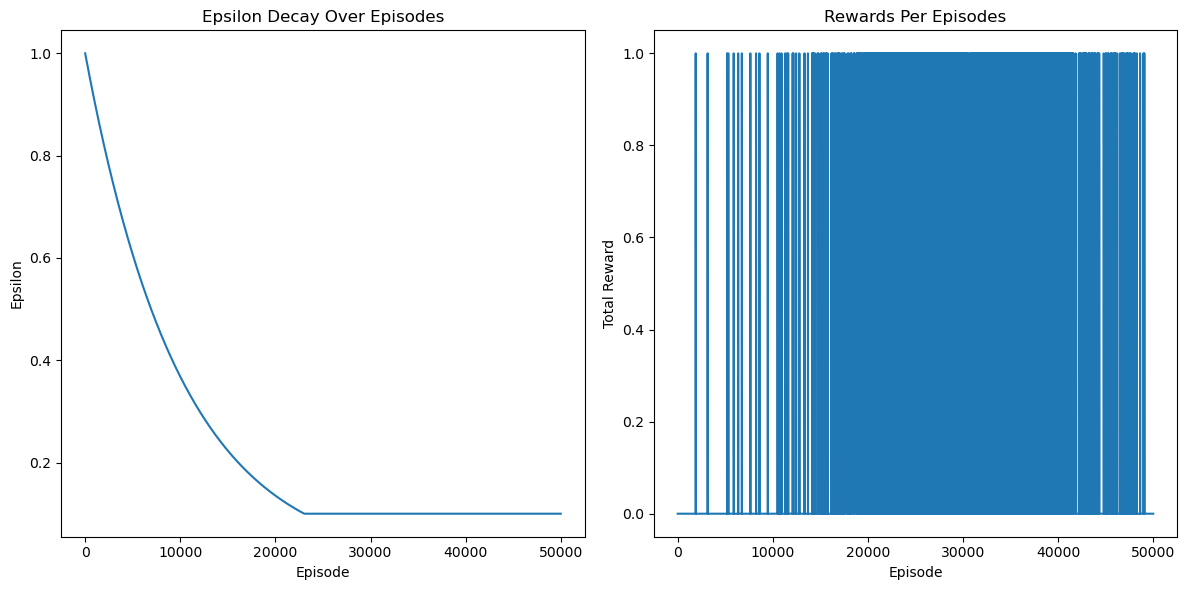

In [16]:
# importing libraries for environments, display and plotting
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# generating map
random_map = generate_random_map(size=5, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# video capture
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

state_size = env.observation_space.n  # number of states
action_size = env.action_space.n      # number of actions
learning_rate = 0.001

# neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# experience replay
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# epsilon-greedy policy parameters
epsilon = 1.0        # exploration rate
epsilon_min = 0.1    
epsilon_decay = 0.9999

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # best action based on Q-values

# training parameters
num_episodes = 50000  
gamma = 0.99         # discount factor

epsilon_values = []
reward_values = []

# training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # one-hot encoding
    total_reward = 0
    done = False

    for step in range(100):
        action = choose_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  

        # modified reward (not used)
        if done and reward == 0:  
            reward = 0
        elif done and reward == 1:  
            reward = 1

        # store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # predict Q-values
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # get target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if (episode + 1) % 10 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

print("Training completed.")

# plotting
plt.figure(figsize=(12, 6))

# epsilon decay
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# rewards per episodes
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [56]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: True)

# exploitation episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}") 

def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# get video
import os
from pathlib import Path

video_path = sorted(Path('./video2').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/Matka/video2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_64187/632396392.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_values = model(torch.tensor(state, dtype=torch.float32))


MoviePy - Building video /Users/Matka/video2/rl-video-episode-0.mp4.
MoviePy - Writing video /Users/Matka/video2/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /Users/Matka/video2/rl-video-episode-0.mp4
Total Reward in test episode: 1.0


### 7x7

In [2]:
# importing libraries for environments, display and plotting
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# generating map
random_map = generate_random_map(size=7, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# video capture
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

state_size = env.observation_space.n  # number of states
action_size = env.action_space.n      # number of actions
learning_rate = 0.001

# neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# experience replay
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# epsilon-greedy policy parameters
epsilon = 1.0        # exploration rate
epsilon_min = 0.1    
epsilon_decay = 0.99999 

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # best action based on Q-values

# training parameters
num_episodes = 500000  
gamma = 0.99         # discount factor

epsilon_values = []
reward_values = []

# training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # one-hot encoding
    total_reward = 0
    done = False

    for step in range(100):
        action = choose_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  

        # modified reward (not used)
        if done and reward == 0:  
            reward = 0
        elif done and reward == 1:  
            reward = 1

        # store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # predict Q-values 
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # get target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if (episode + 1) % 1000 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

    if total_reward == 1:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}") 

print("Training completed.")


Progress:   0%|                                      | 0/500000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_61703/333760696.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
Progress:   0%|                         | 1005/500000 [00:14<1:58:26, 70.22it/s]

Episode: 1000, Total Reward: 0.0, Epsilon: 0.9900497842463938


Progress:   0%|                         | 2007/500000 [00:30<2:08:06, 64.79it/s]

Episode: 2000, Total Reward: 0.0, Epsilon: 0.980198575286327


Progress:   1%|▏                        | 3005/500000 [00:46<2:41:48, 51.19it/s]

Episode: 3000, Total Reward: 0.0, Epsilon: 0.970445387980849


Progress:   1%|▏                        | 4011/500000 [01:02<2:01:25, 68.08it/s]

Episode: 4000, Total Reward: 0.0, Epsilon: 0.9607892469933452


Progress:   1%|▎                        | 5010/500000 [01:18<2:08:18, 64.30it/s]

Episode: 5000, Total Reward: 0.0, Epsilon: 0.9512291866920142


Progress:   1%|▎                        | 6009/500000 [01:35<2:13:30, 61.67it/s]

Episode: 6000, Total Reward: 0.0, Epsilon: 0.9417642510533004


Progress:   1%|▎                        | 7014/500000 [01:52<2:09:54, 63.25it/s]

Episode: 7000, Total Reward: 0.0, Epsilon: 0.932393493566284


Progress:   2%|▍                        | 8003/500000 [02:08<1:43:58, 78.86it/s]

Episode: 8000, Total Reward: 0.0, Epsilon: 0.9231159771380392


Progress:   2%|▍                        | 9013/500000 [02:25<1:51:43, 73.25it/s]

Episode: 9000, Total Reward: 0.0, Epsilon: 0.9139307739999132


Progress:   2%|▍                       | 10003/500000 [02:41<1:56:38, 70.01it/s]

Episode: 10000, Total Reward: 0.0, Epsilon: 0.9048369656147537


Progress:   2%|▌                       | 11013/500000 [02:58<1:57:39, 69.27it/s]

Episode: 11000, Total Reward: 0.0, Epsilon: 0.8958336425850486


Progress:   2%|▌                       | 12011/500000 [03:13<1:51:06, 73.20it/s]

Episode: 12000, Total Reward: 0.0, Epsilon: 0.886919904561988


Progress:   3%|▌                       | 13006/500000 [03:30<2:06:03, 64.39it/s]

Episode: 13000, Total Reward: 0.0, Epsilon: 0.878094860155429


Progress:   3%|▋                       | 14011/500000 [03:47<2:30:24, 53.85it/s]

Episode: 14000, Total Reward: 0.0, Epsilon: 0.8693576268447476


Progress:   3%|▋                       | 15013/500000 [04:02<2:06:28, 63.91it/s]

Episode: 15000, Total Reward: 0.0, Epsilon: 0.860707330890597


Progress:   3%|▊                       | 16006/500000 [04:19<2:30:17, 53.67it/s]

Episode: 16000, Total Reward: 0.0, Epsilon: 0.8521431072475252


Progress:   3%|▊                       | 17005/500000 [04:35<2:24:12, 55.82it/s]

Episode: 17000, Total Reward: 0.0, Epsilon: 0.8436640994774628


Progress:   4%|▊                       | 18006/500000 [04:50<2:07:42, 62.90it/s]

Episode: 18000, Total Reward: 0.0, Epsilon: 0.835269459664089


Progress:   4%|▉                       | 19010/500000 [05:07<2:17:21, 58.37it/s]

Episode: 19000, Total Reward: 0.0, Epsilon: 0.8269583483280317


Progress:   4%|▉                       | 20009/500000 [05:23<1:55:43, 69.13it/s]

Episode: 20000, Total Reward: 0.0, Epsilon: 0.8187299343429234


Progress:   4%|█                       | 21007/500000 [05:40<1:56:46, 68.37it/s]

Episode: 21000, Total Reward: 0.0, Epsilon: 0.8105833948522739


Progress:   4%|█                       | 22009/500000 [05:57<2:14:03, 59.43it/s]

Episode: 22000, Total Reward: 0.0, Epsilon: 0.8025179151872026


Progress:   5%|█                       | 23010/500000 [06:14<2:22:21, 55.84it/s]

Episode: 23000, Total Reward: 0.0, Epsilon: 0.794532688784956


Progress:   5%|█▏                      | 24013/500000 [06:30<1:54:02, 69.56it/s]

Episode: 24000, Total Reward: 0.0, Epsilon: 0.7866269171082529


Progress:   5%|█▏                      | 25008/500000 [06:47<2:20:47, 56.23it/s]

Episode: 25000, Total Reward: 0.0, Epsilon: 0.7787998095654318


Progress:   5%|█▏                      | 26012/500000 [07:03<2:03:58, 63.72it/s]

Episode: 26000, Total Reward: 0.0, Epsilon: 0.771050583431387


Progress:   5%|█▎                      | 27014/500000 [07:20<2:14:43, 58.51it/s]

Episode: 27000, Total Reward: 0.0, Epsilon: 0.7633784637692994


Progress:   5%|█▎                      | 27167/500000 [07:22<2:11:15, 60.04it/s]

Episode: 27156, Total Reward: 1.0, Epsilon: 0.7621885158168007


Progress:   6%|█▎                      | 28011/500000 [07:36<2:11:17, 59.92it/s]

Episode: 28000, Total Reward: 0.0, Epsilon: 0.7557826833531376


Progress:   6%|█▍                      | 29012/500000 [07:53<2:01:12, 64.76it/s]

Episode: 29000, Total Reward: 0.0, Epsilon: 0.7482624825909339


Progress:   6%|█▍                      | 30007/500000 [08:09<2:23:30, 54.59it/s]

Episode: 30000, Total Reward: 0.0, Epsilon: 0.7408171094488248


Progress:   6%|█▍                      | 31009/500000 [08:26<1:55:02, 67.94it/s]

Episode: 31000, Total Reward: 0.0, Epsilon: 0.7334458193758445


Progress:   6%|█▌                      | 32007/500000 [08:43<2:11:18, 59.41it/s]

Episode: 32000, Total Reward: 0.0, Epsilon: 0.7261478752294744


Progress:   7%|█▌                      | 33008/500000 [09:00<2:23:56, 54.07it/s]

Episode: 33000, Total Reward: 0.0, Epsilon: 0.7189225472019154


Progress:   7%|█▋                      | 34005/500000 [09:17<2:05:24, 61.93it/s]

Episode: 34000, Total Reward: 0.0, Epsilon: 0.7117691127471237


Progress:   7%|█▋                      | 35005/500000 [09:35<2:21:54, 54.61it/s]

Episode: 35000, Total Reward: 0.0, Epsilon: 0.7046868565085371


Progress:   7%|█▋                      | 36006/500000 [09:52<2:12:15, 58.47it/s]

Episode: 36000, Total Reward: 0.0, Epsilon: 0.697675070247546


Progress:   7%|█▊                      | 37008/500000 [10:10<1:36:18, 80.12it/s]

Episode: 37000, Total Reward: 0.0, Epsilon: 0.6907330527726694


Progress:   8%|█▊                      | 38007/500000 [10:27<2:07:25, 60.43it/s]

Episode: 38000, Total Reward: 0.0, Epsilon: 0.6838601098694327


Progress:   8%|█▊                      | 39014/500000 [10:44<1:45:33, 72.78it/s]

Episode: 39000, Total Reward: 0.0, Epsilon: 0.6770555542309463


Progress:   8%|█▉                      | 40007/500000 [11:00<1:49:34, 69.97it/s]

Episode: 40000, Total Reward: 0.0, Epsilon: 0.6703187053891713


Progress:   8%|█▉                      | 41004/500000 [11:16<1:52:19, 68.10it/s]

Episode: 41000, Total Reward: 0.0, Epsilon: 0.6636488896468686


Progress:   8%|██                      | 42006/500000 [11:32<2:03:39, 61.73it/s]

Episode: 42000, Total Reward: 0.0, Epsilon: 0.6570454400102405


Progress:   9%|██                      | 43004/500000 [11:49<2:12:41, 57.40it/s]

Episode: 43000, Total Reward: 0.0, Epsilon: 0.6505076961222145


Progress:   9%|██                      | 44008/500000 [12:06<2:27:06, 51.66it/s]

Episode: 44000, Total Reward: 0.0, Epsilon: 0.6440350041964173


Progress:   9%|██▏                     | 45010/500000 [12:22<2:02:04, 62.12it/s]

Episode: 45000, Total Reward: 0.0, Epsilon: 0.6376267169517861


Progress:   9%|██▏                     | 46006/500000 [12:39<1:49:17, 69.23it/s]

Episode: 46000, Total Reward: 0.0, Epsilon: 0.631282193547851


Progress:   9%|██▎                     | 47002/500000 [12:56<2:12:34, 56.95it/s]

Episode: 47000, Total Reward: 0.0, Epsilon: 0.625000799520639


Progress:  10%|██▎                     | 48012/500000 [13:12<1:52:22, 67.03it/s]

Episode: 48000, Total Reward: 0.0, Epsilon: 0.6187819067192317


Progress:  10%|██▎                     | 49011/500000 [13:29<1:59:47, 62.75it/s]

Episode: 49000, Total Reward: 0.0, Epsilon: 0.6126248932429474


Progress:  10%|██▍                     | 50017/500000 [13:46<1:45:50, 70.85it/s]

Episode: 50000, Total Reward: 0.0, Epsilon: 0.606529143379149


Progress:  10%|██▍                     | 51008/500000 [14:03<2:09:29, 57.79it/s]

Episode: 51000, Total Reward: 0.0, Epsilon: 0.6004940475416769


Progress:  10%|██▍                     | 52009/500000 [14:20<2:02:59, 60.71it/s]

Episode: 52000, Total Reward: 0.0, Epsilon: 0.5945190022098814


Progress:  11%|██▌                     | 53011/500000 [14:38<2:01:59, 61.07it/s]

Episode: 53000, Total Reward: 0.0, Epsilon: 0.5886034098682736


Progress:  11%|██▌                     | 54003/500000 [14:54<1:44:50, 70.90it/s]

Episode: 54000, Total Reward: 0.0, Epsilon: 0.5827466789467737


Progress:  11%|██▋                     | 55008/500000 [15:11<1:55:26, 64.24it/s]

Episode: 55000, Total Reward: 0.0, Epsilon: 0.5769482237615552


Progress:  11%|██▋                     | 56014/500000 [15:28<1:54:56, 64.38it/s]

Episode: 56000, Total Reward: 0.0, Epsilon: 0.5712074644564694


Progress:  11%|██▋                     | 57009/500000 [15:44<1:36:58, 76.13it/s]

Episode: 57000, Total Reward: 0.0, Epsilon: 0.5655238269450559


Progress:  12%|██▊                     | 58010/500000 [16:00<1:51:46, 65.90it/s]

Episode: 58000, Total Reward: 0.0, Epsilon: 0.5598967428531466


Progress:  12%|██▊                     | 59006/500000 [16:17<1:50:55, 66.26it/s]

Episode: 59000, Total Reward: 0.0, Epsilon: 0.5543256494620156


Progress:  12%|██▉                     | 60009/500000 [16:34<1:53:15, 64.75it/s]

Episode: 60000, Total Reward: 0.0, Epsilon: 0.5488099896521104


Progress:  12%|██▉                     | 61007/500000 [16:51<2:35:29, 47.06it/s]

Episode: 61000, Total Reward: 0.0, Epsilon: 0.5433492118473379


Progress:  12%|██▉                     | 62009/500000 [17:07<1:51:35, 65.42it/s]

Episode: 62000, Total Reward: 0.0, Epsilon: 0.5379427699599039


Progress:  13%|███                     | 63004/500000 [17:24<2:07:58, 56.91it/s]

Episode: 63000, Total Reward: 0.0, Epsilon: 0.5325901233357102


Progress:  13%|███                     | 64007/500000 [17:41<1:27:30, 83.04it/s]

Episode: 64000, Total Reward: 0.0, Epsilon: 0.52729073670028


Progress:  13%|███                     | 65007/500000 [17:58<1:42:18, 70.86it/s]

Episode: 65000, Total Reward: 0.0, Epsilon: 0.5220440801052326


Progress:  13%|███▏                    | 66007/500000 [18:14<1:44:34, 69.16it/s]

Episode: 66000, Total Reward: 0.0, Epsilon: 0.5168496288752937


Progress:  13%|███▏                    | 67015/500000 [18:31<1:47:59, 66.82it/s]

Episode: 67000, Total Reward: 0.0, Epsilon: 0.5117068635558124


Progress:  14%|███▎                    | 68013/500000 [18:49<2:00:07, 59.94it/s]

Episode: 68000, Total Reward: 0.0, Epsilon: 0.5066152698608287


Progress:  14%|███▎                    | 69003/500000 [19:06<2:20:36, 51.09it/s]

Episode: 69000, Total Reward: 0.0, Epsilon: 0.5015743386216417


Progress:  14%|███▎                    | 70013/500000 [19:23<1:55:38, 61.97it/s]

Episode: 70000, Total Reward: 0.0, Epsilon: 0.4965835657358831


Progress:  14%|███▍                    | 71008/500000 [19:41<1:47:26, 66.54it/s]

Episode: 71000, Total Reward: 0.0, Epsilon: 0.4916424521171163


Progress:  14%|███▍                    | 72012/500000 [19:58<1:36:12, 74.14it/s]

Episode: 72000, Total Reward: 0.0, Epsilon: 0.48675050364491823


Progress:  15%|███▌                    | 73008/500000 [20:14<1:39:09, 71.77it/s]

Episode: 73000, Total Reward: 0.0, Epsilon: 0.4819072311154746


Progress:  15%|███▌                    | 74006/500000 [20:31<2:08:06, 55.42it/s]

Episode: 74000, Total Reward: 0.0, Epsilon: 0.47711215019265096


Progress:  15%|███▌                    | 75014/500000 [20:47<1:53:22, 62.47it/s]

Episode: 75000, Total Reward: 0.0, Epsilon: 0.4723647813595669


Progress:  15%|███▋                    | 76010/500000 [21:03<1:46:02, 66.64it/s]

Episode: 76000, Total Reward: 0.0, Epsilon: 0.46766464987063483


Progress:  15%|███▋                    | 77011/500000 [21:20<1:58:36, 59.44it/s]

Episode: 77000, Total Reward: 0.0, Epsilon: 0.463011285704087


Progress:  16%|███▋                    | 78008/500000 [21:37<2:05:44, 55.94it/s]

Episode: 78000, Total Reward: 0.0, Epsilon: 0.45840422351497584


Progress:  16%|███▊                    | 79008/500000 [21:54<2:01:34, 57.71it/s]

Episode: 79000, Total Reward: 0.0, Epsilon: 0.45384300258863663


Progress:  16%|███▊                    | 80005/500000 [22:12<2:10:44, 53.54it/s]

Episode: 80000, Total Reward: 0.0, Epsilon: 0.44932716679461515


Progress:  16%|███▉                    | 81005/500000 [22:28<1:59:25, 58.47it/s]

Episode: 81000, Total Reward: 0.0, Epsilon: 0.4448562645410515


Progress:  16%|███▉                    | 82005/500000 [22:45<1:59:41, 58.20it/s]

Episode: 82000, Total Reward: 0.0, Epsilon: 0.44042984872952373


Progress:  17%|███▉                    | 83012/500000 [23:02<1:44:33, 66.47it/s]

Episode: 83000, Total Reward: 0.0, Epsilon: 0.436047476710336


Progress:  17%|████                    | 84008/500000 [23:19<1:44:35, 66.28it/s]

Episode: 84000, Total Reward: 0.0, Epsilon: 0.43170871023825186


Progress:  17%|████                    | 85007/500000 [23:37<2:02:52, 56.29it/s]

Episode: 85000, Total Reward: 0.0, Epsilon: 0.4274131154286699


Progress:  17%|████▏                   | 86013/500000 [23:55<1:37:58, 70.42it/s]

Episode: 86000, Total Reward: 0.0, Epsilon: 0.4231602627142337


Progress:  17%|████▏                   | 87004/500000 [24:12<2:06:42, 54.32it/s]

Episode: 87000, Total Reward: 0.0, Epsilon: 0.4189497268018744


Progress:  18%|████▏                   | 88005/500000 [24:29<2:37:43, 43.53it/s]

Episode: 88000, Total Reward: 0.0, Epsilon: 0.4147810866302807


Progress:  18%|████▎                   | 89009/500000 [24:47<2:13:59, 51.12it/s]

Episode: 89000, Total Reward: 0.0, Epsilon: 0.41065392532779377


Progress:  18%|████▎                   | 90002/500000 [25:04<2:14:47, 50.69it/s]

Episode: 90000, Total Reward: 0.0, Epsilon: 0.4065678301707155


Progress:  18%|████▎                   | 91006/500000 [25:25<2:08:52, 52.90it/s]

Episode: 91000, Total Reward: 0.0, Epsilon: 0.40252239254204125


Progress:  18%|████▍                   | 92010/500000 [25:44<2:03:36, 55.01it/s]

Episode: 92000, Total Reward: 0.0, Epsilon: 0.39851720789058975


Progress:  19%|████▍                   | 93009/500000 [26:01<2:00:54, 56.10it/s]

Episode: 93000, Total Reward: 0.0, Epsilon: 0.39455187569055383


Progress:  19%|████▌                   | 94007/500000 [26:18<1:50:13, 61.39it/s]

Episode: 94000, Total Reward: 0.0, Epsilon: 0.3906259994014428


Progress:  19%|████▌                   | 95011/500000 [26:35<2:15:25, 49.84it/s]

Episode: 95000, Total Reward: 0.0, Epsilon: 0.3867391864284302


Progress:  19%|████▌                   | 96006/500000 [26:53<2:07:46, 52.70it/s]

Episode: 96000, Total Reward: 0.0, Epsilon: 0.38289104808309254


Progress:  19%|████▋                   | 97005/500000 [27:09<1:51:49, 60.06it/s]

Episode: 97000, Total Reward: 0.0, Epsilon: 0.37908119954454067


Progress:  20%|████▋                   | 98010/500000 [27:27<2:00:29, 55.60it/s]

Episode: 98000, Total Reward: 0.0, Epsilon: 0.3753092598209357


Progress:  20%|████▊                   | 99006/500000 [27:44<1:59:38, 55.86it/s]

Episode: 99000, Total Reward: 0.0, Epsilon: 0.3715748517113911


Progress:  20%|████▌                  | 100007/500000 [28:02<1:56:30, 57.22it/s]

Episode: 100000, Total Reward: 0.0, Epsilon: 0.3678776017682482


Progress:  20%|████▋                  | 101006/500000 [28:19<1:50:03, 60.42it/s]

Episode: 101000, Total Reward: 0.0, Epsilon: 0.3642171402597344


Progress:  20%|████▋                  | 102008/500000 [28:37<2:00:18, 55.14it/s]

Episode: 102000, Total Reward: 0.0, Epsilon: 0.3605931011329881


Progress:  21%|████▋                  | 103007/500000 [28:55<1:39:50, 66.28it/s]

Episode: 103000, Total Reward: 0.0, Epsilon: 0.3570051219774521


Progress:  21%|████▊                  | 104005/500000 [29:13<1:56:38, 56.59it/s]

Episode: 104000, Total Reward: 0.0, Epsilon: 0.35345284398863397


Progress:  21%|████▊                  | 105012/500000 [29:31<1:46:37, 61.74it/s]

Episode: 105000, Total Reward: 0.0, Epsilon: 0.34993591193222057


Progress:  21%|████▉                  | 106008/500000 [29:48<1:40:22, 65.41it/s]

Episode: 106000, Total Reward: 0.0, Epsilon: 0.34645397410856066


Progress:  21%|████▉                  | 107004/500000 [30:06<1:40:32, 65.14it/s]

Episode: 107000, Total Reward: 0.0, Epsilon: 0.34300668231748466


Progress:  22%|████▉                  | 108005/500000 [30:24<1:48:06, 60.43it/s]

Episode: 108000, Total Reward: 0.0, Epsilon: 0.3395936918234972


Progress:  22%|█████                  | 109008/500000 [30:42<1:59:56, 54.33it/s]

Episode: 109000, Total Reward: 0.0, Epsilon: 0.33621466132128963


Progress:  22%|█████                  | 110005/500000 [30:59<1:44:13, 62.37it/s]

Episode: 110000, Total Reward: 0.0, Epsilon: 0.3328692529016169


Progress:  22%|█████                  | 111008/500000 [31:17<1:51:04, 58.37it/s]

Episode: 111000, Total Reward: 0.0, Epsilon: 0.3295571320175043


Progress:  22%|█████▏                 | 112006/500000 [31:34<2:03:48, 52.23it/s]

Episode: 112000, Total Reward: 0.0, Epsilon: 0.3262779674507909


Progress:  23%|█████▏                 | 113008/500000 [31:53<2:07:22, 50.63it/s]

Episode: 113000, Total Reward: 0.0, Epsilon: 0.3230314312790066


Progress:  23%|█████▏                 | 114007/500000 [32:11<1:57:38, 54.68it/s]

Episode: 114000, Total Reward: 0.0, Epsilon: 0.31981719884258314


Progress:  23%|█████▎                 | 115008/500000 [32:28<1:37:48, 65.60it/s]

Episode: 115000, Total Reward: 0.0, Epsilon: 0.31663494871238457


Progress:  23%|█████▎                 | 116012/500000 [32:46<1:35:55, 66.72it/s]

Episode: 116000, Total Reward: 0.0, Epsilon: 0.3134843626575645


Progress:  23%|█████▍                 | 117003/500000 [33:03<1:57:09, 54.48it/s]

Episode: 117000, Total Reward: 0.0, Epsilon: 0.31036512561373913


Progress:  24%|█████▍                 | 118005/500000 [33:21<1:34:44, 67.19it/s]

Episode: 118000, Total Reward: 0.0, Epsilon: 0.3072769256514861


Progress:  24%|█████▍                 | 119005/500000 [33:39<1:39:34, 63.77it/s]

Episode: 119000, Total Reward: 0.0, Epsilon: 0.30421945394514904


Progress:  24%|█████▌                 | 120010/500000 [33:57<1:51:07, 56.99it/s]

Episode: 120000, Total Reward: 0.0, Epsilon: 0.3011924047419503


Progress:  24%|█████▌                 | 121006/500000 [34:14<1:43:47, 60.86it/s]

Episode: 121000, Total Reward: 0.0, Epsilon: 0.29819547533141966


Progress:  24%|█████▌                 | 122006/500000 [34:32<2:02:16, 51.53it/s]

Episode: 122000, Total Reward: 0.0, Epsilon: 0.29522836601512276


Progress:  25%|█████▋                 | 123004/500000 [34:50<1:59:02, 52.78it/s]

Episode: 123000, Total Reward: 0.0, Epsilon: 0.29229078007668685


Progress:  25%|█████▋                 | 124011/500000 [35:08<1:52:59, 55.46it/s]

Episode: 124000, Total Reward: 0.0, Epsilon: 0.2893824237521339


Progress:  25%|█████▊                 | 125008/500000 [35:26<1:50:15, 56.68it/s]

Episode: 125000, Total Reward: 0.0, Epsilon: 0.28650300620049846


Progress:  25%|█████▊                 | 126007/500000 [35:44<1:35:11, 65.48it/s]

Episode: 126000, Total Reward: 0.0, Epsilon: 0.28365223947474627


Progress:  25%|█████▊                 | 127008/500000 [36:02<1:36:42, 64.28it/s]

Episode: 127000, Total Reward: 0.0, Epsilon: 0.28082983849297816


Progress:  26%|█████▉                 | 128012/500000 [36:20<1:44:40, 59.23it/s]

Episode: 128000, Total Reward: 0.0, Epsilon: 0.27803552100992185


Progress:  26%|█████▉                 | 129003/500000 [36:38<2:00:11, 51.45it/s]

Episode: 129000, Total Reward: 0.0, Epsilon: 0.27526900758870637


Progress:  26%|█████▉                 | 130007/500000 [36:55<1:19:17, 77.77it/s]

Episode: 130000, Total Reward: 0.0, Epsilon: 0.27253002157291667


Progress:  26%|██████                 | 131008/500000 [37:13<1:51:54, 54.96it/s]

Episode: 131000, Total Reward: 0.0, Epsilon: 0.2698182890589307


Progress:  26%|██████                 | 132003/500000 [37:31<1:44:10, 58.87it/s]

Episode: 132000, Total Reward: 0.0, Epsilon: 0.2671335388685256


Progress:  27%|██████                 | 133012/500000 [37:49<1:55:54, 52.77it/s]

Episode: 133000, Total Reward: 0.0, Epsilon: 0.2644755025217599


Progress:  27%|██████▏                | 134012/500000 [38:07<1:43:15, 59.07it/s]

Episode: 134000, Total Reward: 0.0, Epsilon: 0.2618439142101241


Progress:  27%|██████▏                | 135015/500000 [38:25<1:30:56, 66.89it/s]

Episode: 135000, Total Reward: 0.0, Epsilon: 0.2592385107699642


Progress:  27%|██████▎                | 136006/500000 [38:43<1:29:08, 68.05it/s]

Episode: 136000, Total Reward: 0.0, Epsilon: 0.25665903165615905


Progress:  27%|██████▎                | 137009/500000 [39:00<1:32:56, 65.09it/s]

Episode: 137000, Total Reward: 0.0, Epsilon: 0.25410521891606896


Progress:  28%|██████▎                | 138008/500000 [39:18<1:38:41, 61.13it/s]

Episode: 138000, Total Reward: 0.0, Epsilon: 0.2515768171637373


Progress:  28%|██████▍                | 139009/500000 [39:37<1:39:57, 60.19it/s]

Episode: 139000, Total Reward: 0.0, Epsilon: 0.2490735735543521


Progress:  28%|██████▍                | 140013/500000 [39:55<1:41:47, 58.94it/s]

Episode: 140000, Total Reward: 0.0, Epsilon: 0.2465952377589643


Progress:  28%|██████▍                | 141015/500000 [40:13<1:31:09, 65.64it/s]

Episode: 141000, Total Reward: 0.0, Epsilon: 0.2441415619394505


Progress:  28%|██████▌                | 142007/500000 [40:31<1:51:21, 53.58it/s]

Episode: 142000, Total Reward: 0.0, Epsilon: 0.2417123007237305


Progress:  29%|██████▌                | 143007/500000 [40:49<1:50:44, 53.73it/s]

Episode: 143000, Total Reward: 0.0, Epsilon: 0.2393072111812284


Progress:  29%|██████▌                | 144004/500000 [41:07<1:50:49, 53.54it/s]

Episode: 144000, Total Reward: 0.0, Epsilon: 0.23692605279858062


Progress:  29%|██████▋                | 145005/500000 [41:25<1:39:10, 59.66it/s]

Episode: 145000, Total Reward: 0.0, Epsilon: 0.23456858745558423


Progress:  29%|██████▋                | 146010/500000 [41:43<1:42:06, 57.78it/s]

Episode: 146000, Total Reward: 0.0, Epsilon: 0.23223457940138229


Progress:  29%|██████▊                | 147009/500000 [42:01<1:44:50, 56.11it/s]

Episode: 147000, Total Reward: 0.0, Epsilon: 0.22992379523088996


Progress:  30%|██████▊                | 148002/500000 [42:18<1:40:13, 58.54it/s]

Episode: 148000, Total Reward: 0.0, Epsilon: 0.22763600386145424


Progress:  30%|██████▊                | 149001/500000 [42:36<1:34:14, 62.07it/s]

Episode: 149000, Total Reward: 0.0, Epsilon: 0.22537097650974372


Progress:  30%|██████▉                | 150004/500000 [42:54<1:47:32, 54.24it/s]

Episode: 150000, Total Reward: 0.0, Epsilon: 0.2231284866688706


Progress:  30%|██████▉                | 151010/500000 [43:12<1:29:06, 65.27it/s]

Episode: 151000, Total Reward: 0.0, Epsilon: 0.22090831008573955


Progress:  30%|██████▉                | 152006/500000 [43:30<1:50:04, 52.69it/s]

Episode: 152000, Total Reward: 0.0, Epsilon: 0.21871022473862184


Progress:  31%|███████                | 153011/500000 [43:48<1:47:35, 53.75it/s]

Episode: 153000, Total Reward: 0.0, Epsilon: 0.21653401081495274


Progress:  31%|███████                | 154006/500000 [44:06<1:58:43, 48.57it/s]

Episode: 154000, Total Reward: 0.0, Epsilon: 0.21437945068935033


Progress:  31%|███████▏               | 155006/500000 [44:25<2:03:57, 46.39it/s]

Episode: 155000, Total Reward: 0.0, Epsilon: 0.2122463289018516


Progress:  31%|███████▏               | 156010/500000 [44:43<1:35:54, 59.78it/s]

Episode: 156000, Total Reward: 0.0, Epsilon: 0.21013443213636668


Progress:  31%|███████▏               | 157006/500000 [45:01<1:47:55, 52.97it/s]

Episode: 157000, Total Reward: 0.0, Epsilon: 0.208043549199348


Progress:  32%|███████▎               | 158004/500000 [45:19<2:06:27, 45.07it/s]

Episode: 158000, Total Reward: 0.0, Epsilon: 0.20597347099866842


Progress:  32%|███████▎               | 159007/500000 [45:38<2:07:34, 44.55it/s]

Episode: 159000, Total Reward: 0.0, Epsilon: 0.20392399052271246


Progress:  32%|███████▎               | 160003/500000 [45:56<1:38:47, 57.36it/s]

Episode: 160000, Total Reward: 0.0, Epsilon: 0.20189490281967454


Progress:  32%|███████▍               | 161009/500000 [46:15<1:24:13, 67.08it/s]

Episode: 161000, Total Reward: 0.0, Epsilon: 0.1998860049770656


Progress:  32%|███████▍               | 162006/500000 [46:34<1:42:13, 55.10it/s]

Episode: 162000, Total Reward: 0.0, Epsilon: 0.19789709610141687


Progress:  33%|███████▍               | 163006/500000 [46:53<1:27:50, 63.94it/s]

Episode: 163000, Total Reward: 0.0, Epsilon: 0.19592797729819508


Progress:  33%|███████▌               | 164009/500000 [47:11<1:49:28, 51.15it/s]

Episode: 164000, Total Reward: 0.0, Epsilon: 0.19397845165191013


Progress:  33%|███████▌               | 165008/500000 [47:29<1:39:16, 56.24it/s]

Episode: 165000, Total Reward: 0.0, Epsilon: 0.19204832420642307


Progress:  33%|███████▋               | 166011/500000 [47:47<1:31:06, 61.10it/s]

Episode: 166000, Total Reward: 0.0, Epsilon: 0.19013740194545012


Progress:  33%|███████▋               | 167004/500000 [48:05<1:45:09, 52.78it/s]

Episode: 167000, Total Reward: 0.0, Epsilon: 0.18824549377326252


Progress:  34%|███████▋               | 168010/500000 [48:23<1:24:45, 65.28it/s]

Episode: 168000, Total Reward: 0.0, Epsilon: 0.1863724104955739


Progress:  34%|███████▊               | 169006/500000 [48:42<1:29:58, 61.31it/s]

Episode: 169000, Total Reward: 0.0, Epsilon: 0.18451796480062288


Progress:  34%|███████▊               | 170012/500000 [49:01<1:32:38, 59.37it/s]

Episode: 170000, Total Reward: 0.0, Epsilon: 0.18268197124044036


Progress:  34%|███████▊               | 171004/500000 [49:21<1:58:42, 46.19it/s]

Episode: 171000, Total Reward: 0.0, Epsilon: 0.1808642462123039


Progress:  34%|███████▉               | 172007/500000 [49:39<1:44:56, 52.09it/s]

Episode: 172000, Total Reward: 0.0, Epsilon: 0.17906460794037798


Progress:  35%|███████▉               | 173006/500000 [49:57<1:30:44, 60.07it/s]

Episode: 173000, Total Reward: 0.0, Epsilon: 0.1772828764575356


Progress:  35%|████████               | 174008/500000 [50:15<1:40:12, 54.22it/s]

Episode: 174000, Total Reward: 0.0, Epsilon: 0.17551887358736293


Progress:  35%|████████               | 175009/500000 [50:35<1:56:40, 46.43it/s]

Episode: 175000, Total Reward: 0.0, Epsilon: 0.17377242292633877


Progress:  35%|████████               | 176009/500000 [50:54<1:48:34, 49.74it/s]

Episode: 176000, Total Reward: 0.0, Epsilon: 0.17204334982619462


Progress:  35%|████████▏              | 177009/500000 [51:12<1:37:38, 55.13it/s]

Episode: 177000, Total Reward: 0.0, Epsilon: 0.1703314813764502


Progress:  36%|████████▏              | 178010/500000 [51:31<1:24:04, 63.82it/s]

Episode: 178000, Total Reward: 0.0, Epsilon: 0.1686366463871232


Progress:  36%|████████▏              | 179004/500000 [51:49<1:48:12, 49.44it/s]

Episode: 179000, Total Reward: 0.0, Epsilon: 0.16695867537160639


Progress:  36%|████████▎              | 180015/500000 [52:08<1:27:34, 60.90it/s]

Episode: 180000, Total Reward: 0.0, Epsilon: 0.16529740052972253


Progress:  36%|████████▎              | 181008/500000 [52:27<1:26:09, 61.71it/s]

Episode: 181000, Total Reward: 0.0, Epsilon: 0.16365265573094104


Progress:  36%|████████▎              | 182005/500000 [52:45<1:28:32, 59.85it/s]

Episode: 182000, Total Reward: 0.0, Epsilon: 0.1620242764977676


Progress:  37%|████████▍              | 183007/500000 [53:02<1:32:56, 56.85it/s]

Episode: 183000, Total Reward: 0.0, Epsilon: 0.16041209998929246


Progress:  37%|████████▍              | 184004/500000 [53:21<1:33:35, 56.28it/s]

Episode: 184000, Total Reward: 0.0, Epsilon: 0.1588159649849096


Progress:  37%|████████▌              | 185008/500000 [53:39<1:34:08, 55.77it/s]

Episode: 185000, Total Reward: 0.0, Epsilon: 0.15723571186819257


Progress:  37%|████████▌              | 186009/500000 [53:57<1:25:34, 61.15it/s]

Episode: 186000, Total Reward: 0.0, Epsilon: 0.15567118261093182


Progress:  37%|████████▌              | 187006/500000 [54:16<1:49:31, 47.63it/s]

Episode: 187000, Total Reward: 0.0, Epsilon: 0.15412222075733398


Progress:  38%|████████▋              | 188001/500000 [54:34<1:49:03, 47.68it/s]

Episode: 188000, Total Reward: 0.0, Epsilon: 0.15258867140837346


Progress:  38%|████████▋              | 189009/500000 [54:53<1:42:38, 50.50it/s]

Episode: 189000, Total Reward: 0.0, Epsilon: 0.15107038120630345


Progress:  38%|████████▋              | 190012/500000 [55:12<1:33:11, 55.44it/s]

Episode: 190000, Total Reward: 0.0, Epsilon: 0.14956719831932092


Progress:  38%|████████▊              | 191006/500000 [55:32<1:52:32, 45.76it/s]

Episode: 191000, Total Reward: 0.0, Epsilon: 0.14807897242638118


Progress:  38%|████████▊              | 191999/500000 [55:50<1:35:33, 53.72it/s]

Episode: 192000, Total Reward: 0.0, Epsilon: 0.1466055547021663


Progress:  39%|████████▉              | 193007/500000 [56:08<2:01:10, 42.23it/s]

Episode: 193000, Total Reward: 0.0, Epsilon: 0.1451467978022025


Progress:  39%|████████▉              | 194010/500000 [56:28<1:35:20, 53.49it/s]

Episode: 194000, Total Reward: 0.0, Epsilon: 0.14370255584812555


Progress:  39%|████████▉              | 195007/500000 [56:47<1:34:26, 53.82it/s]

Episode: 195000, Total Reward: 0.0, Epsilon: 0.14227268441309207


Progress:  39%|█████████              | 196006/500000 [57:06<1:37:04, 52.19it/s]

Episode: 196000, Total Reward: 0.0, Epsilon: 0.14085704050733694


Progress:  39%|█████████              | 197004/500000 [57:25<2:02:41, 41.16it/s]

Episode: 197000, Total Reward: 0.0, Epsilon: 0.13945548256387427


Progress:  40%|█████████              | 198004/500000 [57:44<1:30:20, 55.72it/s]

Episode: 198000, Total Reward: 0.0, Epsilon: 0.13806787042434024


Progress:  40%|█████████▏             | 199013/500000 [58:02<1:11:59, 69.68it/s]

Episode: 199000, Total Reward: 0.0, Epsilon: 0.1366940653249772


Progress:  40%|█████████▏             | 200010/500000 [58:20<1:13:21, 68.16it/s]

Episode: 200000, Total Reward: 0.0, Epsilon: 0.13533392988275578


Progress:  40%|█████████▏             | 201007/500000 [58:38<1:29:22, 55.75it/s]

Episode: 201000, Total Reward: 0.0, Epsilon: 0.13398732808163916


Progress:  40%|█████████▎             | 202007/500000 [58:57<1:31:03, 54.55it/s]

Episode: 202000, Total Reward: 0.0, Epsilon: 0.1326541252589777


Progress:  41%|█████████▎             | 203009/500000 [59:16<1:26:59, 56.90it/s]

Episode: 203000, Total Reward: 0.0, Epsilon: 0.13133418809204478


Progress:  41%|█████████▍             | 204002/500000 [59:34<1:41:44, 48.49it/s]

Episode: 204000, Total Reward: 0.0, Epsilon: 0.1300273845847044


Progress:  41%|█████████▍             | 205001/500000 [59:53<1:11:38, 68.63it/s]

Episode: 205000, Total Reward: 0.0, Epsilon: 0.12873358405420932


Progress:  41%|████████▋            | 206006/500000 [1:00:12<1:29:20, 54.84it/s]

Episode: 206000, Total Reward: 0.0, Epsilon: 0.127452657118135


Progress:  41%|████████▋            | 207004/500000 [1:00:31<1:55:20, 42.34it/s]

Episode: 207000, Total Reward: 0.0, Epsilon: 0.12618447568143878


Progress:  42%|████████▋            | 208011/500000 [1:00:51<1:21:55, 59.40it/s]

Episode: 208000, Total Reward: 0.0, Epsilon: 0.12492891292365225


Progress:  42%|████████▊            | 209005/500000 [1:01:09<1:31:00, 53.29it/s]

Episode: 209000, Total Reward: 0.0, Epsilon: 0.12368584328619818


Progress:  42%|████████▊            | 210007/500000 [1:01:28<1:23:12, 58.09it/s]

Episode: 210000, Total Reward: 0.0, Epsilon: 0.1224551424598337


Progress:  42%|████████▊            | 211007/500000 [1:01:47<1:29:46, 53.65it/s]

Episode: 211000, Total Reward: 0.0, Epsilon: 0.1212366873722196


Progress:  42%|████████▉            | 212008/500000 [1:02:06<1:23:06, 57.76it/s]

Episode: 212000, Total Reward: 0.0, Epsilon: 0.12003035617561353


Progress:  43%|████████▉            | 213007/500000 [1:02:26<1:17:23, 61.80it/s]

Episode: 213000, Total Reward: 0.0, Epsilon: 0.11883602823468375


Progress:  43%|████████▉            | 214008/500000 [1:02:45<1:24:12, 56.60it/s]

Episode: 214000, Total Reward: 0.0, Epsilon: 0.11765358411444692


Progress:  43%|█████████            | 215008/500000 [1:03:05<1:30:47, 52.31it/s]

Episode: 215000, Total Reward: 0.0, Epsilon: 0.116482905568323


Progress:  43%|█████████            | 216007/500000 [1:03:24<1:25:47, 55.17it/s]

Episode: 216000, Total Reward: 0.0, Epsilon: 0.11532387552631093


Progress:  43%|█████████            | 217006/500000 [1:03:42<1:48:12, 43.59it/s]

Episode: 217000, Total Reward: 0.0, Epsilon: 0.11417637808328207


Progress:  44%|█████████▏           | 218005/500000 [1:04:01<1:31:39, 51.27it/s]

Episode: 218000, Total Reward: 0.0, Epsilon: 0.11304029848738797


Progress:  44%|█████████▏           | 219005/500000 [1:04:21<1:30:32, 51.73it/s]

Episode: 219000, Total Reward: 0.0, Epsilon: 0.11191552312858626


Progress:  44%|█████████▏           | 220006/500000 [1:04:39<1:24:15, 55.38it/s]

Episode: 220000, Total Reward: 0.0, Epsilon: 0.11080193952727901


Progress:  44%|█████████▎           | 221012/500000 [1:04:58<1:11:48, 64.75it/s]

Episode: 221000, Total Reward: 0.0, Epsilon: 0.10969943632306436


Progress:  44%|█████████▎           | 222006/500000 [1:05:17<1:47:11, 43.23it/s]

Episode: 222000, Total Reward: 0.0, Epsilon: 0.10860790326360067


Progress:  45%|█████████▎           | 223014/500000 [1:05:36<1:21:40, 56.52it/s]

Episode: 223000, Total Reward: 0.0, Epsilon: 0.10752723119358107


Progress:  45%|█████████▍           | 224004/500000 [1:05:54<1:32:52, 49.53it/s]

Episode: 224000, Total Reward: 0.0, Epsilon: 0.10645731204381705


Progress:  45%|█████████▍           | 225007/500000 [1:06:12<1:15:25, 60.76it/s]

Episode: 225000, Total Reward: 0.0, Epsilon: 0.10539803882043212


Progress:  45%|█████████▍           | 226010/500000 [1:06:31<1:18:11, 58.40it/s]

Episode: 226000, Total Reward: 0.0, Epsilon: 0.10434930559416189


Progress:  45%|█████████▌           | 227007/500000 [1:06:50<1:20:17, 56.66it/s]

Episode: 227000, Total Reward: 0.0, Epsilon: 0.10331100748976073


Progress:  46%|█████████▌           | 228005/500000 [1:07:08<1:08:38, 66.05it/s]

Episode: 228000, Total Reward: 0.0, Epsilon: 0.10228304067551519


Progress:  46%|█████████▌           | 229007/500000 [1:07:27<1:15:27, 59.86it/s]

Episode: 229000, Total Reward: 0.0, Epsilon: 0.10126530235285876


Progress:  46%|█████████▋           | 230006/500000 [1:07:47<1:28:15, 50.98it/s]

Episode: 230000, Total Reward: 0.0, Epsilon: 0.1002576907460938


Progress:  46%|█████████▋           | 231009/500000 [1:08:06<1:26:38, 51.75it/s]

Episode: 231000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▋           | 232006/500000 [1:08:25<1:40:57, 44.24it/s]

Episode: 232000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 233012/500000 [1:08:44<1:15:41, 58.78it/s]

Episode: 233000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 234013/500000 [1:09:04<1:22:46, 53.56it/s]

Episode: 234000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 235003/500000 [1:09:23<1:40:28, 43.96it/s]

Episode: 235000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▉           | 236006/500000 [1:09:42<1:36:12, 45.73it/s]

Episode: 236000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▉           | 237008/500000 [1:10:01<1:35:15, 46.02it/s]

Episode: 237000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|█████████▉           | 238007/500000 [1:10:20<1:13:44, 59.22it/s]

Episode: 238000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████▉            | 239013/500000 [1:10:40<55:44, 78.04it/s]

Episode: 239000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████           | 240009/500000 [1:10:58<1:31:17, 47.47it/s]

Episode: 240000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████           | 241003/500000 [1:11:17<1:20:20, 53.73it/s]

Episode: 241000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████▏          | 242006/500000 [1:11:37<1:18:48, 54.56it/s]

Episode: 242000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▏          | 243012/500000 [1:11:56<1:02:49, 68.17it/s]

Episode: 243000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▏          | 244009/500000 [1:12:15<1:18:22, 54.44it/s]

Episode: 244000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 245006/500000 [1:12:34<1:29:30, 47.48it/s]

Episode: 245000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 246008/500000 [1:12:53<1:06:56, 63.24it/s]

Episode: 246000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 247005/500000 [1:13:13<1:47:47, 39.12it/s]

Episode: 247000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▍          | 248009/500000 [1:13:32<1:16:56, 54.58it/s]

Episode: 248000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▍          | 249005/500000 [1:13:51<1:08:03, 61.47it/s]

Episode: 249000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 250007/500000 [1:14:10<1:11:56, 57.92it/s]

Episode: 250000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 251005/500000 [1:14:29<1:23:09, 49.91it/s]

Episode: 251000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 252005/500000 [1:14:48<1:29:14, 46.32it/s]

Episode: 252000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▋          | 253007/500000 [1:15:09<1:13:11, 56.24it/s]

Episode: 253000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|███████████▋           | 254004/500000 [1:15:28<59:59, 68.34it/s]

Episode: 254000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▋          | 255007/500000 [1:15:47<1:30:32, 45.10it/s]

Episode: 255000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▊          | 256005/500000 [1:16:06<1:19:38, 51.06it/s]

Episode: 256000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▊          | 257006/500000 [1:16:25<1:13:10, 55.35it/s]

Episode: 257000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▊          | 258003/500000 [1:16:44<1:18:27, 51.40it/s]

Episode: 258000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▊          | 258723/500000 [1:16:59<1:29:32, 44.91it/s]

Episode: 258718, Total Reward: 1.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 259007/500000 [1:17:05<1:39:01, 40.56it/s]

Episode: 259000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 260006/500000 [1:17:24<1:26:38, 46.17it/s]

Episode: 260000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 261006/500000 [1:17:43<1:27:59, 45.27it/s]

Episode: 261000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|███████████          | 262006/500000 [1:18:03<1:11:46, 55.27it/s]

Episode: 262000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████          | 263008/500000 [1:18:22<1:17:39, 50.86it/s]

Episode: 263000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████          | 264005/500000 [1:18:41<1:27:13, 45.09it/s]

Episode: 264000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 265004/500000 [1:19:00<1:23:32, 46.88it/s]

Episode: 265000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 266004/500000 [1:19:20<1:24:49, 45.98it/s]

Episode: 266000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 267008/500000 [1:19:39<1:36:55, 40.07it/s]

Episode: 267000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 268008/500000 [1:20:00<1:16:19, 50.66it/s]

Episode: 268000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 269006/500000 [1:20:20<1:10:05, 54.93it/s]

Episode: 269000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 270010/500000 [1:20:39<1:12:09, 53.12it/s]

Episode: 270000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▍         | 271009/500000 [1:20:57<1:13:04, 52.23it/s]

Episode: 271000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|████████████▌          | 272007/500000 [1:21:17<59:05, 64.31it/s]

Episode: 272000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▍         | 273007/500000 [1:21:36<1:03:53, 59.21it/s]

Episode: 273000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 274009/500000 [1:21:56<1:13:14, 51.42it/s]

Episode: 274000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 275007/500000 [1:22:15<1:19:49, 46.98it/s]

Episode: 275000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 276007/500000 [1:22:34<1:08:08, 54.78it/s]

Episode: 276000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▋         | 277011/500000 [1:22:53<1:08:01, 54.64it/s]

Episode: 277000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▋         | 278007/500000 [1:23:12<1:01:21, 60.30it/s]

Episode: 278000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▋         | 279006/500000 [1:23:31<1:13:03, 50.42it/s]

Episode: 279000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▊         | 280013/500000 [1:23:50<1:05:33, 55.93it/s]

Episode: 280000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▊         | 281007/500000 [1:24:10<1:18:36, 46.43it/s]

Episode: 281000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|████████████▉          | 282004/500000 [1:24:29<57:00, 63.73it/s]

Episode: 282000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|███████████▉         | 283002/500000 [1:24:49<1:17:57, 46.39it/s]

Episode: 283000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|███████████▉         | 284006/500000 [1:25:08<1:02:50, 57.28it/s]

Episode: 284000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|█████████████          | 285004/500000 [1:25:27<54:04, 66.27it/s]

Episode: 285000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|█████████████▏         | 286005/500000 [1:25:47<55:37, 64.11it/s]

Episode: 286000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|████████████         | 287005/500000 [1:26:07<1:16:43, 46.27it/s]

Episode: 287000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|█████████████▏         | 288003/500000 [1:26:25<53:22, 66.20it/s]

Episode: 288000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|█████████████▎         | 289006/500000 [1:26:44<57:20, 61.33it/s]

Episode: 289000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▏        | 290009/500000 [1:27:04<1:01:16, 57.12it/s]

Episode: 290000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▏        | 291005/500000 [1:27:24<1:13:58, 47.08it/s]

Episode: 291000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▎        | 292005/500000 [1:27:43<1:10:45, 48.99it/s]

Episode: 292000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▎        | 293003/500000 [1:28:02<1:05:23, 52.76it/s]

Episode: 293000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▎        | 294008/500000 [1:28:21<1:09:48, 49.18it/s]

Episode: 294000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|█████████████▌         | 295013/500000 [1:28:40<59:23, 57.53it/s]

Episode: 295000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▍        | 296008/500000 [1:28:59<1:20:39, 42.15it/s]

Episode: 296000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▍        | 297008/500000 [1:29:17<1:08:14, 49.58it/s]

Episode: 297000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▌        | 298009/500000 [1:29:37<1:07:44, 49.70it/s]

Episode: 298000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|█████████████▊         | 299015/500000 [1:29:57<54:05, 61.93it/s]

Episode: 299000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|█████████████▊         | 300013/500000 [1:30:17<50:55, 65.44it/s]

Episode: 300000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▋        | 301004/500000 [1:30:36<1:12:09, 45.96it/s]

Episode: 301000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|█████████████▉         | 302011/500000 [1:30:55<53:41, 61.46it/s]

Episode: 302000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|█████████████▉         | 303007/500000 [1:31:13<54:23, 60.37it/s]

Episode: 303000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|█████████████▉         | 304000/500000 [1:31:32<57:44, 56.57it/s]

Episode: 304000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▊        | 305001/500000 [1:31:52<1:02:49, 51.73it/s]

Episode: 305000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▊        | 306002/500000 [1:32:11<1:01:12, 52.83it/s]

Episode: 306000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|██████████████         | 307001/500000 [1:32:30<52:34, 61.18it/s]

Episode: 307000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|████████████▉        | 307999/500000 [1:32:49<1:00:44, 52.69it/s]

Episode: 308000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|████████████▉        | 309009/500000 [1:33:08<1:01:23, 51.85it/s]

Episode: 309000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|█████████████        | 310007/500000 [1:33:28<1:07:30, 46.90it/s]

Episode: 310000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|██████████████▎        | 311016/500000 [1:33:47<47:26, 66.40it/s]

Episode: 311000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|██████████████▎        | 312011/500000 [1:34:06<51:48, 60.48it/s]

Episode: 312000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▏       | 313007/500000 [1:34:26<1:03:17, 49.24it/s]

Episode: 313000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|██████████████▍        | 314006/500000 [1:34:46<59:04, 52.47it/s]

Episode: 314000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▏       | 315012/500000 [1:35:05<1:05:24, 47.14it/s]

Episode: 315000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▎       | 316008/500000 [1:35:25<1:05:07, 47.09it/s]

Episode: 316000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|██████████████▌        | 317006/500000 [1:35:45<59:42, 51.08it/s]

Episode: 317000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▎       | 318010/500000 [1:36:03<1:00:45, 49.93it/s]

Episode: 318000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|██████████████▋        | 319009/500000 [1:36:21<50:19, 59.94it/s]

Episode: 319000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▍       | 320002/500000 [1:36:41<1:05:31, 45.79it/s]

Episode: 320000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|██████████████▊        | 321001/500000 [1:37:01<54:32, 54.70it/s]

Episode: 321000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▌       | 322006/500000 [1:37:20<1:06:59, 44.28it/s]

Episode: 322000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|██████████████▊        | 323003/500000 [1:37:39<53:55, 54.71it/s]

Episode: 323000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|██████████████▉        | 324012/500000 [1:37:58<56:09, 52.23it/s]

Episode: 324000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|██████████████▉        | 325001/500000 [1:38:17<45:50, 63.61it/s]

Episode: 325000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|██████████████▉        | 326009/500000 [1:38:37<58:25, 49.64it/s]

Episode: 326000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|███████████████        | 327005/500000 [1:38:56<48:42, 59.20it/s]

Episode: 327000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|███████████████        | 328007/500000 [1:39:16<52:46, 54.32it/s]

Episode: 328000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▊       | 329005/500000 [1:39:36<1:11:45, 39.72it/s]

Episode: 329000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|███████████████▏       | 330008/500000 [1:39:55<47:42, 59.38it/s]

Episode: 330000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|███████████████▏       | 331004/500000 [1:40:14<43:54, 64.15it/s]

Episode: 331000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|███████████████▎       | 332005/500000 [1:40:33<52:15, 53.57it/s]

Episode: 332000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|███████████████▎       | 333008/500000 [1:40:52<51:57, 53.57it/s]

Episode: 333000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|███████████████▎       | 334004/500000 [1:41:12<46:23, 59.63it/s]

Episode: 334000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|██████████████       | 335002/500000 [1:41:31<1:15:08, 36.60it/s]

Episode: 335000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|███████████████▍       | 336005/500000 [1:41:51<51:32, 53.03it/s]

Episode: 336000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|███████████████▌       | 337008/500000 [1:42:11<52:46, 51.47it/s]

Episode: 337000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|███████████████▌       | 338011/500000 [1:42:32<48:42, 55.42it/s]

Episode: 338000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|███████████████▌       | 339013/500000 [1:42:52<49:07, 54.62it/s]

Episode: 339000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|███████████████▋       | 340015/500000 [1:43:11<42:44, 62.38it/s]

Episode: 340000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|███████████████▋       | 341010/500000 [1:43:30<52:04, 50.89it/s]

Episode: 341000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|███████████████▋       | 342006/500000 [1:43:49<53:35, 49.14it/s]

Episode: 342000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|███████████████▊       | 343007/500000 [1:44:08<45:44, 57.21it/s]

Episode: 343000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|███████████████▊       | 344013/500000 [1:44:28<52:05, 49.90it/s]

Episode: 344000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|███████████████▊       | 345013/500000 [1:44:46<44:15, 58.37it/s]

Episode: 345000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|███████████████▉       | 346010/500000 [1:45:05<47:03, 54.53it/s]

Episode: 346000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|███████████████▉       | 347007/500000 [1:45:24<43:22, 58.78it/s]

Episode: 347000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|████████████████       | 348004/500000 [1:45:43<51:42, 49.00it/s]

Episode: 348000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|████████████████       | 349012/500000 [1:46:02<44:23, 56.68it/s]

Episode: 349000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|████████████████       | 350010/500000 [1:46:21<51:48, 48.25it/s]

Episode: 350000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|████████████████▏      | 351007/500000 [1:46:41<54:58, 45.17it/s]

Episode: 351000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|████████████████▏      | 352008/500000 [1:47:00<45:57, 53.67it/s]

Episode: 352000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|████████████████▏      | 353008/500000 [1:47:20<39:20, 62.27it/s]

Episode: 353000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|████████████████▎      | 354003/500000 [1:47:40<34:15, 71.03it/s]

Episode: 354000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|████████████████▎      | 355012/500000 [1:47:59<40:17, 59.96it/s]

Episode: 355000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|████████████████▍      | 356008/500000 [1:48:18<51:15, 46.82it/s]

Episode: 356000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|████████████████▍      | 357003/500000 [1:48:36<44:51, 53.14it/s]

Episode: 357000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|████████████████▍      | 358007/500000 [1:48:55<45:40, 51.82it/s]

Episode: 358000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|████████████████▌      | 359009/500000 [1:49:15<43:00, 54.65it/s]

Episode: 359000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|████████████████▌      | 360005/500000 [1:49:34<38:25, 60.71it/s]

Episode: 360000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|████████████████▌      | 361007/500000 [1:49:53<35:40, 64.94it/s]

Episode: 361000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|████████████████▋      | 362009/500000 [1:50:13<45:37, 50.40it/s]

Episode: 362000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|████████████████▋      | 363007/500000 [1:50:32<43:03, 53.03it/s]

Episode: 363000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|████████████████▋      | 364006/500000 [1:50:50<34:54, 64.92it/s]

Episode: 364000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|████████████████▊      | 365008/500000 [1:51:09<45:31, 49.43it/s]

Episode: 365000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|████████████████▊      | 366013/500000 [1:51:29<38:29, 58.02it/s]

Episode: 366000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|████████████████▉      | 367004/500000 [1:51:47<35:56, 61.66it/s]

Episode: 367000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|████████████████▉      | 368008/500000 [1:52:07<40:30, 54.32it/s]

Episode: 368000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|████████████████▉      | 369007/500000 [1:52:25<40:12, 54.30it/s]

Episode: 369000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|█████████████████      | 370006/500000 [1:52:44<41:51, 51.75it/s]

Episode: 370000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|█████████████████      | 371006/500000 [1:53:03<39:12, 54.83it/s]

Episode: 371000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|█████████████████      | 372012/500000 [1:53:21<34:47, 61.30it/s]

Episode: 372000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|█████████████████▏     | 373007/500000 [1:53:41<40:31, 52.22it/s]

Episode: 373000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|█████████████████▏     | 374002/500000 [1:54:01<40:24, 51.96it/s]

Episode: 374000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|█████████████████▎     | 375007/500000 [1:54:21<55:07, 37.79it/s]

Episode: 375000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|█████████████████▎     | 376004/500000 [1:54:41<49:06, 42.08it/s]

Episode: 376000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|█████████████████▎     | 377008/500000 [1:55:00<37:08, 55.18it/s]

Episode: 377000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|█████████████████▍     | 378004/500000 [1:55:18<31:02, 65.50it/s]

Episode: 378000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|█████████████████▍     | 379007/500000 [1:55:37<37:32, 53.73it/s]

Episode: 379000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|█████████████████▍     | 380011/500000 [1:55:57<35:44, 55.96it/s]

Episode: 380000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|█████████████████▌     | 381003/500000 [1:56:15<37:49, 52.43it/s]

Episode: 381000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|█████████████████▌     | 382012/500000 [1:56:34<30:16, 64.95it/s]

Episode: 382000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|█████████████████▌     | 383007/500000 [1:56:53<45:03, 43.28it/s]

Episode: 383000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|█████████████████▋     | 384007/500000 [1:57:12<37:47, 51.14it/s]

Episode: 384000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|█████████████████▋     | 384999/500000 [1:57:30<32:49, 58.39it/s]

Episode: 385000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|█████████████████▊     | 386006/500000 [1:57:50<44:00, 43.18it/s]

Episode: 386000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|█████████████████▊     | 387004/500000 [1:58:10<42:51, 43.95it/s]

Episode: 387000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|█████████████████▊     | 388012/500000 [1:58:29<28:08, 66.32it/s]

Episode: 388000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|█████████████████▉     | 389011/500000 [1:58:47<27:42, 66.77it/s]

Episode: 389000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|█████████████████▉     | 390004/500000 [1:59:06<35:12, 52.06it/s]

Episode: 390000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|█████████████████▉     | 391006/500000 [1:59:26<35:38, 50.97it/s]

Episode: 391000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|██████████████████     | 392006/500000 [1:59:44<37:32, 47.95it/s]

Episode: 392000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|██████████████████     | 393009/500000 [2:00:04<34:10, 52.18it/s]

Episode: 393000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|██████████████████     | 394006/500000 [2:00:24<35:22, 49.94it/s]

Episode: 394000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|██████████████████▏    | 395008/500000 [2:00:43<30:00, 58.32it/s]

Episode: 395000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|██████████████████▏    | 396008/500000 [2:01:03<26:10, 66.23it/s]

Episode: 396000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|██████████████████▎    | 397006/500000 [2:01:22<36:28, 47.07it/s]

Episode: 397000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|██████████████████▎    | 398009/500000 [2:01:41<33:17, 51.05it/s]

Episode: 398000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|██████████████████▎    | 399006/500000 [2:02:00<37:06, 45.35it/s]

Episode: 399000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|██████████████████▍    | 400004/500000 [2:02:19<40:24, 41.24it/s]

Episode: 400000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|██████████████████▍    | 401015/500000 [2:02:39<25:37, 64.37it/s]

Episode: 401000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|██████████████████▍    | 402000/500000 [2:02:58<32:20, 50.49it/s]

Episode: 402000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|██████████████████▌    | 403003/500000 [2:03:16<36:03, 44.84it/s]

Episode: 403000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|██████████████████▌    | 404003/500000 [2:03:35<26:41, 59.95it/s]

Episode: 404000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|██████████████████▋    | 405010/500000 [2:03:53<29:26, 53.77it/s]

Episode: 405000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|██████████████████▋    | 406013/500000 [2:04:12<29:01, 53.97it/s]

Episode: 406000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|██████████████████▋    | 407006/500000 [2:04:31<30:54, 50.15it/s]

Episode: 407000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|██████████████████▊    | 408004/500000 [2:04:51<28:25, 53.96it/s]

Episode: 408000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|██████████████████▊    | 409003/500000 [2:05:10<47:17, 32.07it/s]

Episode: 409000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|██████████████████▊    | 410008/500000 [2:05:31<27:11, 55.17it/s]

Episode: 410000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|██████████████████▉    | 411006/500000 [2:05:51<27:39, 53.63it/s]

Episode: 411000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|██████████████████▉    | 412007/500000 [2:06:10<30:20, 48.34it/s]

Episode: 412000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|██████████████████▉    | 413004/500000 [2:06:29<24:53, 58.25it/s]

Episode: 413000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|███████████████████    | 414011/500000 [2:06:48<25:57, 55.19it/s]

Episode: 414000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|███████████████████    | 415009/500000 [2:07:06<29:36, 47.84it/s]

Episode: 415000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|███████████████████▏   | 416008/500000 [2:07:26<30:32, 45.84it/s]

Episode: 416000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|███████████████████▏   | 417007/500000 [2:07:45<22:47, 60.70it/s]

Episode: 417000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|███████████████████▏   | 418001/500000 [2:08:05<29:37, 46.12it/s]

Episode: 418000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|███████████████████▎   | 419003/500000 [2:08:25<21:21, 63.22it/s]

Episode: 419000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|███████████████████▎   | 420003/500000 [2:08:44<24:49, 53.70it/s]

Episode: 420000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|███████████████████▎   | 421012/500000 [2:09:03<20:23, 64.54it/s]

Episode: 421000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|███████████████████▍   | 422002/500000 [2:09:22<27:16, 47.66it/s]

Episode: 422000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|███████████████████▍   | 423007/500000 [2:09:42<17:48, 72.07it/s]

Episode: 423000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|███████████████████▌   | 424010/500000 [2:10:01<21:10, 59.82it/s]

Episode: 424000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|███████████████████▌   | 425007/500000 [2:10:21<28:24, 44.00it/s]

Episode: 425000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|███████████████████▌   | 426008/500000 [2:10:40<20:17, 60.76it/s]

Episode: 426000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|███████████████████▋   | 427009/500000 [2:11:00<18:28, 65.85it/s]

Episode: 427000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|███████████████████▋   | 428009/500000 [2:11:18<24:13, 49.54it/s]

Episode: 428000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|███████████████████▋   | 429007/500000 [2:11:38<21:41, 54.53it/s]

Episode: 429000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|███████████████████▊   | 430012/500000 [2:11:56<17:59, 64.86it/s]

Episode: 430000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|███████████████████▊   | 431008/500000 [2:12:16<21:19, 53.91it/s]

Episode: 431000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|███████████████████▊   | 432009/500000 [2:12:35<22:02, 51.43it/s]

Episode: 432000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|███████████████████▉   | 433006/500000 [2:12:54<23:47, 46.92it/s]

Episode: 433000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|███████████████████▉   | 434008/500000 [2:13:13<16:02, 68.54it/s]

Episode: 434000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 435002/500000 [2:13:32<19:54, 54.40it/s]

Episode: 435000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 436014/500000 [2:13:51<15:33, 68.51it/s]

Episode: 436000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 437010/500000 [2:14:10<19:10, 54.73it/s]

Episode: 437000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▏  | 438008/500000 [2:14:29<20:14, 51.06it/s]

Episode: 438000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▏  | 439006/500000 [2:14:49<19:33, 51.97it/s]

Episode: 439000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▏  | 440011/500000 [2:15:07<15:16, 65.46it/s]

Episode: 440000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▎  | 441012/500000 [2:15:26<16:31, 59.51it/s]

Episode: 441000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▎  | 442011/500000 [2:15:45<18:29, 52.28it/s]

Episode: 442000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 443005/500000 [2:16:05<20:03, 47.37it/s]

Episode: 443000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 444005/500000 [2:16:24<16:26, 56.77it/s]

Episode: 444000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 445007/500000 [2:16:42<18:19, 50.03it/s]

Episode: 445000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▌  | 446009/500000 [2:17:01<13:37, 66.05it/s]

Episode: 446000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▌  | 447005/500000 [2:17:20<16:45, 52.72it/s]

Episode: 447000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▌  | 448008/500000 [2:17:39<16:47, 51.61it/s]

Episode: 448000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 449004/500000 [2:17:57<11:36, 73.18it/s]

Episode: 449000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 450012/500000 [2:18:17<13:28, 61.84it/s]

Episode: 450000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 451006/500000 [2:18:36<17:26, 46.80it/s]

Episode: 451000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▊  | 452008/500000 [2:18:56<15:25, 51.87it/s]

Episode: 452000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▊  | 453007/500000 [2:19:16<15:06, 51.86it/s]

Episode: 453000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▉  | 454006/500000 [2:19:35<15:17, 50.11it/s]

Episode: 454000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▉  | 455009/500000 [2:19:54<16:57, 44.23it/s]

Episode: 455000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▉  | 456004/500000 [2:20:14<13:38, 53.75it/s]

Episode: 456000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|█████████████████████  | 457013/500000 [2:20:34<13:00, 55.05it/s]

Episode: 457000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████  | 458004/500000 [2:20:53<12:05, 57.85it/s]

Episode: 458000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████  | 459008/500000 [2:21:12<12:31, 54.58it/s]

Episode: 459000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▏ | 460003/500000 [2:21:31<15:59, 41.70it/s]

Episode: 460000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▏ | 461004/500000 [2:21:50<12:53, 50.42it/s]

Episode: 461000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▎ | 462012/500000 [2:22:09<10:28, 60.43it/s]

Episode: 462000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▎ | 463006/500000 [2:22:28<12:23, 49.77it/s]

Episode: 463000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▎ | 464009/500000 [2:22:47<09:36, 62.42it/s]

Episode: 464000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 465011/500000 [2:23:06<10:46, 54.16it/s]

Episode: 465000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 466003/500000 [2:23:25<09:25, 60.17it/s]

Episode: 466000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 467006/500000 [2:23:44<10:17, 53.46it/s]

Episode: 467000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 468006/500000 [2:24:04<13:41, 38.92it/s]

Episode: 468000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 469006/500000 [2:24:23<08:46, 58.83it/s]

Episode: 469000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 470013/500000 [2:24:42<07:46, 64.24it/s]

Episode: 470000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▋ | 471010/500000 [2:25:01<07:18, 66.13it/s]

Episode: 471000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▋ | 472004/500000 [2:25:19<08:49, 52.88it/s]

Episode: 472000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 473008/500000 [2:25:39<07:13, 62.24it/s]

Episode: 473000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 474011/500000 [2:25:58<07:19, 59.08it/s]

Episode: 474000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 475008/500000 [2:26:18<06:54, 60.31it/s]

Episode: 475000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▉ | 476005/500000 [2:26:38<08:33, 46.76it/s]

Episode: 476000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▉ | 477014/500000 [2:26:57<06:34, 58.33it/s]

Episode: 477000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|█████████████████████▉ | 478011/500000 [2:27:16<06:46, 54.06it/s]

Episode: 478000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████ | 479007/500000 [2:27:35<06:52, 50.88it/s]

Episode: 479000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████ | 480004/500000 [2:27:55<07:57, 41.84it/s]

Episode: 480000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████▏| 481007/500000 [2:28:13<05:58, 53.03it/s]

Episode: 481000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████▏| 482010/500000 [2:28:32<05:12, 57.61it/s]

Episode: 482000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▏| 483004/500000 [2:28:51<05:36, 50.52it/s]

Episode: 483000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 484003/500000 [2:29:11<04:49, 55.18it/s]

Episode: 484000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 485015/500000 [2:29:30<03:37, 68.88it/s]

Episode: 485000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 486008/500000 [2:29:48<04:26, 52.44it/s]

Episode: 486000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▍| 487006/500000 [2:30:08<04:12, 51.44it/s]

Episode: 487000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▍| 488005/500000 [2:30:27<03:34, 55.80it/s]

Episode: 488000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▍| 489004/500000 [2:30:45<03:53, 47.17it/s]

Episode: 489000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▌| 490008/500000 [2:31:04<03:14, 51.31it/s]

Episode: 490000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▌| 491003/500000 [2:31:23<03:04, 48.70it/s]

Episode: 491000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▋| 492009/500000 [2:31:42<02:09, 61.69it/s]

Episode: 492000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▋| 493011/500000 [2:32:01<02:03, 56.68it/s]

Episode: 493000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▋| 494007/500000 [2:32:21<01:38, 60.97it/s]

Episode: 494000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 495004/500000 [2:32:39<01:21, 61.27it/s]

Episode: 495000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 496008/500000 [2:33:00<01:18, 51.03it/s]

Episode: 496000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 497006/500000 [2:33:19<01:06, 45.16it/s]

Episode: 497000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|██████████████████████▉| 498010/500000 [2:33:38<00:32, 60.69it/s]

Episode: 498000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|██████████████████████▉| 499015/500000 [2:33:58<00:14, 67.53it/s]

Episode: 499000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|███████████████████████| 500000/500000 [2:34:17<00:00, 54.01it/s]

Episode: 500000, Total Reward: 0.0, Epsilon: 0.1
Training completed.


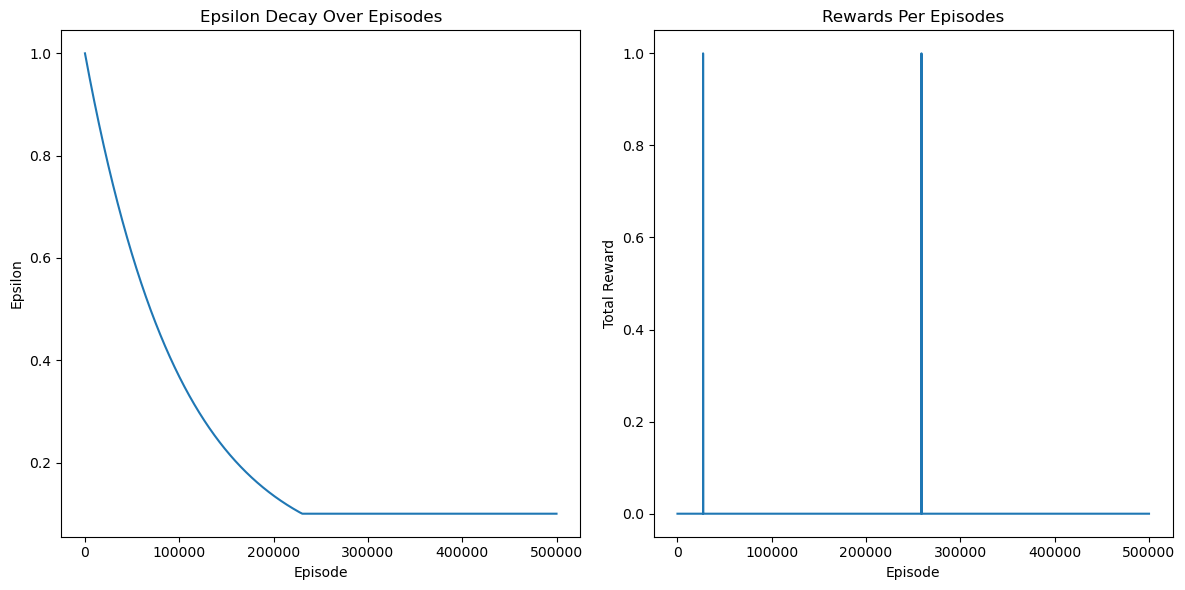

In [3]:
# plotting 7x7
plt.figure(figsize=(12, 6))

# epsilon decay
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# rewards per episode
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [ ]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: True)

# exploitation episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  

def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')
    
# get video
import os
from pathlib import Path

video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

### 8x8

In [18]:
# # delete video folder
# import shutil
# folder_path = "./video3"  # Adjust this to the exact path of the folder
# shutil.rmtree(folder_path)

In [4]:
# importing libraries for environments, display and plotting
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# generating map
random_map = generate_random_map(size=8, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# video capture
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

state_size = env.observation_space.n  # number of states
action_size = env.action_space.n      # number of actions
learning_rate = 0.001

# neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# experience replay
memory_size = 5000
batch_size = 128
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# epsilon-greedy policy parameters
epsilon = 1.0        # exploration rate 
epsilon_min = 0.1   
epsilon_decay = 0.99999 

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # best action based on Q-values

# training parameters
num_episodes = 100000  
gamma = 0.99         # discount factor

epsilon_values = []
reward_values = []

# training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # one-hot encoding 
    total_reward = 0
    done = False

    for step in range(100):
        action = choose_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1] 

        # modified reward (not used)
        if done and reward == 0:  
            reward = 0
        elif done and reward == 1:  
            reward = 1

        # store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # predict Q-values
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # get target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if (episode + 1) % 10 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

    if total_reward == 1:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}") 

print("Training completed.")


Progress:   0%|                                      | 0/100000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_15722/299282814.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
Progress:  17%|████▎                     | 16503/100000 [05:39<33:49, 41.15it/s]

Episode: 16498, Total Reward: 1.0, Epsilon: 0.8479099626863316


Progress: 100%|█████████████████████████| 100000/100000 [31:00<00:00, 53.76it/s]

Training completed.


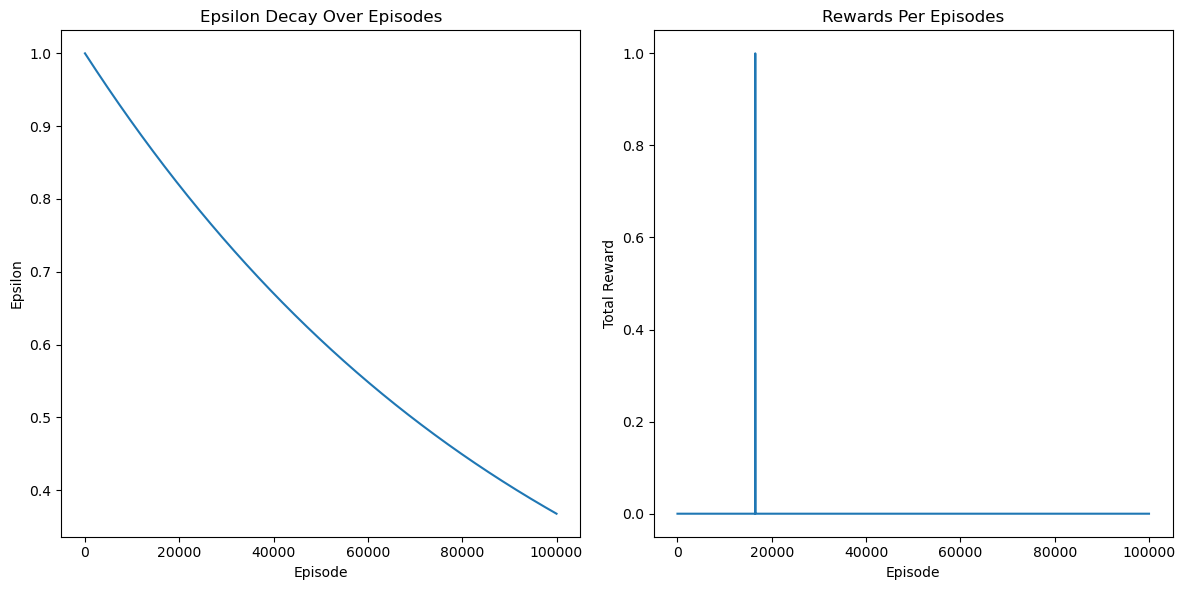

In [5]:
# plotting 8x8
plt.figure(figsize=(12, 6))

# epsilon decay
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# rewards per episode
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [ ]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video3', episode_trigger=lambda x: True)

# exploitation episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  

def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')

# get video
import os
from pathlib import Path

video_path = sorted(Path('./video3').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))

### 10x10

In [1]:
# importing libraries for environments, display and plotting
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque 
from tqdm import tqdm
import matplotlib.pyplot as plt

# generating map
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env.reset()
env.render()

# video capture
env = gym.wrappers.RecordVideo(env, video_folder='./video2', episode_trigger=lambda x: (x+1) % 10 == 0)

state_size = env.observation_space.n  # number of states
action_size = env.action_space.n      # number of actions
learning_rate = 0.0005

# neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

# DQN model, loss function, and optimizer
model = DQN(state_size, action_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# experience replay
memory_size = 10000
batch_size = 256
replay_memory = deque(maxlen=memory_size)

def store_experience(state, action, reward, next_state, done):
    replay_memory.append((state, action, reward, next_state, done))

# epsilon-greedy policy parameters
epsilon = 1.0        # exploration rate 
epsilon_min = 0.1   
epsilon_decay = 0.99995 

def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # random action
    with torch.no_grad():
        q_values = model(torch.tensor(state, dtype=torch.float32))
    return torch.argmax(q_values).item()  # best action based on Q-values

# training parameters
num_episodes = 500000  
gamma = 0.99         # discount factor

epsilon_values = []
reward_values = []

# training loop
for episode in tqdm(range(num_episodes), desc="Progress"):
    state, _ = env.reset()
    state = np.identity(state_size)[state:state+1]  # one-hot encoding 
    total_reward = 0
    done = False

    for step in range(100):
        action = choose_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.identity(state_size)[next_state:next_state+1]  

        # modified reward (not used)
        if done and reward == 0:  
            reward = 0
        elif done and reward == 1:  
            reward = 1

        # store experience in replay memory
        store_experience(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # sample random batch from memory and train
        if len(replay_memory) >= batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
            actions_mb = torch.tensor([exp[1] for exp in minibatch], dtype=torch.long)
            rewards_mb = torch.tensor([exp[2] for exp in minibatch], dtype=torch.float32)
            next_states_mb = torch.tensor([exp[3][0] for exp in minibatch], dtype=torch.float32)
            dones_mb = torch.tensor([exp[4] for exp in minibatch], dtype=torch.float32)

            # predict Q-values 
            current_qs = model(states_mb)
            next_qs = model(next_states_mb)

            # get target Q-values
            target_qs = current_qs.clone()
            for i in range(batch_size):
                if dones_mb[i]:
                    target_qs[i, actions_mb[i]] = rewards_mb[i]
                else:
                    target_qs[i, actions_mb[i]] = rewards_mb[i] + gamma * torch.max(next_qs[i])

            loss = loss_fn(current_qs, target_qs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    epsilon_values.append(epsilon)
    reward_values.append(total_reward)

    if (episode + 1) % 1000 == 0:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}")

    if total_reward == 1:
        tqdm.write(f"Episode: {episode + 1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon}") 

print("Training completed.")


Progress:   0%|                                      | 0/500000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/vs/96pv3sg15cs6fv1_pwr524x00000gp/T/ipykernel_35757/2477564213.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states_mb = torch.tensor([exp[0][0] for exp in minibatch], dtype=torch.float32)
Progress:   0%|                         | 1002/500000 [00:56<9:08:50, 15.15it/s]

Episode: 1000, Total Reward: 0.0, Epsilon: 0.9512282354250445


Progress:   0%|                         | 2002/500000 [01:55<8:40:39, 15.94it/s]

Episode: 2000, Total Reward: 0.0, Epsilon: 0.9048351558698455


Progress:   1%|▏                        | 3001/500000 [02:57<9:26:00, 14.63it/s]

Episode: 3000, Total Reward: 0.0, Epsilon: 0.8607047486686187


Progress:   1%|▏                        | 4003/500000 [03:58<9:24:14, 14.65it/s]

Episode: 4000, Total Reward: 0.0, Epsilon: 0.8187266592980071


Progress:   1%|▎                        | 5004/500000 [04:58<6:28:42, 21.22it/s]

Episode: 5000, Total Reward: 0.0, Epsilon: 0.7787959154194843


Progress:   1%|▎                        | 6002/500000 [06:00<7:53:09, 17.40it/s]

Episode: 6000, Total Reward: 0.0, Epsilon: 0.7408126643807084


Progress:   1%|▎                        | 7000/500000 [07:00<8:44:44, 15.66it/s]

Episode: 7000, Total Reward: 0.0, Epsilon: 0.7046819235193887


Progress:   2%|▍                        | 8003/500000 [08:01<8:54:25, 15.34it/s]

Episode: 8000, Total Reward: 0.0, Epsilon: 0.6703133426452752


Progress:   2%|▍                        | 9002/500000 [09:05<8:10:45, 16.67it/s]

Episode: 9000, Total Reward: 0.0, Epsilon: 0.6376209781063263


Progress:   2%|▍                       | 10003/500000 [10:07<8:29:55, 16.02it/s]

Episode: 10000, Total Reward: 0.0, Epsilon: 0.6065230778740716


Progress:   2%|▌                      | 11002/500000 [11:08<10:15:55, 13.23it/s]

Episode: 11000, Total Reward: 0.0, Epsilon: 0.5769418771107209


Progress:   2%|▌                       | 12003/500000 [12:09<7:08:41, 18.97it/s]

Episode: 12000, Total Reward: 0.0, Epsilon: 0.5488034037068446


Progress:   3%|▌                       | 13003/500000 [13:12<7:43:55, 17.50it/s]

Episode: 13000, Total Reward: 0.0, Epsilon: 0.5220372933033217


Progress:   3%|▋                       | 14003/500000 [14:15<4:48:55, 28.03it/s]

Episode: 14000, Total Reward: 0.0, Epsilon: 0.4965766133349839


Progress:   3%|▋                       | 15004/500000 [15:18<5:48:07, 23.22it/s]

Episode: 15000, Total Reward: 0.0, Epsilon: 0.47235769565598273


Progress:   3%|▊                       | 16002/500000 [16:22<7:56:11, 16.94it/s]

Episode: 16000, Total Reward: 0.0, Epsilon: 0.44931997732828144


Progress:   3%|▊                       | 17000/500000 [17:27<9:48:53, 13.67it/s]

Episode: 17000, Total Reward: 0.0, Epsilon: 0.42740584917520186


Progress:   4%|▊                       | 18002/500000 [18:34<9:31:37, 14.05it/s]

Episode: 18000, Total Reward: 0.0, Epsilon: 0.4065605117212704


Progress:   4%|▊                      | 19000/500000 [19:41<10:34:46, 12.63it/s]

Episode: 19000, Total Reward: 0.0, Epsilon: 0.3867318381581281


Progress:   4%|▉                      | 20002/500000 [21:00<12:07:36, 10.99it/s]

Episode: 20000, Total Reward: 0.0, Epsilon: 0.36787024399384166


Progress:   4%|▉                      | 21002/500000 [22:21<11:18:04, 11.77it/s]

Episode: 21000, Total Reward: 0.0, Epsilon: 0.3499285630596428


Progress:   4%|█                      | 22001/500000 [23:51<18:42:02,  7.10it/s]

Episode: 22000, Total Reward: 0.0, Epsilon: 0.3328619295640452


Progress:   5%|█                      | 23000/500000 [25:20<10:42:28, 12.37it/s]

Episode: 23000, Total Reward: 0.0, Epsilon: 0.3166276658993829


Progress:   5%|█                      | 24000/500000 [26:45<10:02:17, 13.17it/s]

Episode: 24000, Total Reward: 0.0, Epsilon: 0.30118517592022176


Progress:   5%|█▏                      | 25002/500000 [28:12<8:49:04, 14.96it/s]

Episode: 25000, Total Reward: 0.0, Epsilon: 0.28649584342677537


Progress:   5%|█▏                     | 26003/500000 [29:45<10:30:02, 12.54it/s]

Episode: 26000, Total Reward: 0.0, Epsilon: 0.27252293559946167


Progress:   5%|█▎                      | 27005/500000 [31:06<7:50:45, 16.75it/s]

Episode: 27000, Total Reward: 0.0, Epsilon: 0.25923151114312915


Progress:   6%|█▎                      | 28002/500000 [32:29<8:03:16, 16.28it/s]

Episode: 28000, Total Reward: 0.0, Epsilon: 0.24658833291124654


Progress:   6%|█▎                     | 29001/500000 [33:48<13:42:45,  9.54it/s]

Episode: 29000, Total Reward: 0.0, Epsilon: 0.23456178479156892


Progress:   6%|█▍                      | 30002/500000 [35:05<7:46:07, 16.80it/s]

Episode: 30000, Total Reward: 0.0, Epsilon: 0.22312179264543314


Progress:   6%|█▍                      | 31006/500000 [36:19<5:32:44, 23.49it/s]

Episode: 31000, Total Reward: 0.0, Epsilon: 0.21223974910298832


Progress:   6%|█▌                      | 32002/500000 [37:30<9:11:25, 14.15it/s]

Episode: 32000, Total Reward: 0.0, Epsilon: 0.20188844202629033


Progress:   7%|█▌                     | 33001/500000 [38:53<11:52:06, 10.93it/s]

Episode: 33000, Total Reward: 0.0, Epsilon: 0.19204198646137974


Progress:   7%|█▋                      | 34002/500000 [40:26<8:56:27, 14.48it/s]

Episode: 34000, Total Reward: 0.0, Epsilon: 0.182675759909179


Progress:   7%|█▌                     | 35002/500000 [42:08<13:54:47,  9.28it/s]

Episode: 35000, Total Reward: 0.0, Epsilon: 0.17376634075333758


Progress:   7%|█▋                     | 36001/500000 [43:46<15:21:12,  8.39it/s]

Episode: 36000, Total Reward: 0.0, Epsilon: 0.16529144969106427


Progress:   7%|█▊                      | 37001/500000 [45:23<9:20:06, 13.78it/s]

Episode: 37000, Total Reward: 0.0, Epsilon: 0.15722989402047877


Progress:   8%|█▊                      | 38001/500000 [47:04<8:17:17, 15.48it/s]

Episode: 38000, Total Reward: 0.0, Epsilon: 0.149561514645167


Progress:   8%|█▊                      | 38999/500000 [48:43<7:09:07, 17.90it/s]

Episode: 39000, Total Reward: 0.0, Epsilon: 0.14226713566341942


Progress:   8%|█▊                     | 40001/500000 [50:15<11:46:37, 10.85it/s]

Episode: 40000, Total Reward: 0.0, Epsilon: 0.1353285164160905


Progress:   8%|█▉                     | 41002/500000 [51:56<14:20:59,  8.89it/s]

Episode: 41000, Total Reward: 0.0, Epsilon: 0.12872830587316683


Progress:   8%|█▉                     | 41999/500000 [53:35<13:24:41,  9.49it/s]

Episode: 42000, Total Reward: 0.0, Epsilon: 0.12244999924498769


Progress:   9%|█▉                     | 43002/500000 [55:19<11:41:54, 10.85it/s]

Episode: 43000, Total Reward: 0.0, Epsilon: 0.11647789670960802


Progress:   9%|██                      | 44002/500000 [56:54<8:58:23, 14.12it/s]

Episode: 44000, Total Reward: 0.0, Epsilon: 0.11079706415310114


Progress:   9%|██                     | 45000/500000 [58:35<12:59:51,  9.72it/s]

Episode: 45000, Total Reward: 0.0, Epsilon: 0.10539329582462997


Progress:   9%|█▉                   | 46001/500000 [1:00:16<13:01:49,  9.68it/s]

Episode: 46000, Total Reward: 0.0, Epsilon: 0.10025307881289267


Progress:   9%|█▉                   | 47001/500000 [1:02:00<13:51:25,  9.08it/s]

Episode: 47000, Total Reward: 0.0, Epsilon: 0.1


Progress:  10%|██                    | 48000/500000 [1:03:40<9:11:57, 13.65it/s]

Episode: 48000, Total Reward: 0.0, Epsilon: 0.1


Progress:  10%|██                   | 49002/500000 [1:05:22<13:14:05,  9.47it/s]

Episode: 49000, Total Reward: 0.0, Epsilon: 0.1


Progress:  10%|██                   | 50002/500000 [1:07:00<16:10:18,  7.73it/s]

Episode: 50000, Total Reward: 0.0, Epsilon: 0.1


Progress:  10%|██▏                   | 51001/500000 [1:08:41<8:20:06, 14.96it/s]

Episode: 51000, Total Reward: 0.0, Epsilon: 0.1


Progress:  10%|██▏                  | 52002/500000 [1:10:15<10:17:09, 12.10it/s]

Episode: 52000, Total Reward: 0.0, Epsilon: 0.1


Progress:  11%|██▎                   | 53000/500000 [1:11:36<6:18:20, 19.69it/s]

Episode: 53000, Total Reward: 0.0, Epsilon: 0.1


Progress:  11%|██▍                   | 54001/500000 [1:12:47<9:19:40, 13.28it/s]

Episode: 54000, Total Reward: 0.0, Epsilon: 0.1


Progress:  11%|██▎                  | 55002/500000 [1:13:54<12:41:21,  9.74it/s]

Episode: 55000, Total Reward: 0.0, Epsilon: 0.1


Progress:  11%|██▎                  | 56002/500000 [1:15:00<10:44:13, 11.49it/s]

Episode: 56000, Total Reward: 0.0, Epsilon: 0.1


Progress:  11%|██▌                   | 57002/500000 [1:16:08<7:10:46, 17.14it/s]

Episode: 57000, Total Reward: 0.0, Epsilon: 0.1


Progress:  12%|██▌                   | 58001/500000 [1:17:10<6:36:27, 18.58it/s]

Episode: 58000, Total Reward: 0.0, Epsilon: 0.1


Progress:  12%|██▌                   | 59001/500000 [1:18:10<4:57:46, 24.68it/s]

Episode: 59000, Total Reward: 0.0, Epsilon: 0.1


Progress:  12%|██▋                   | 60002/500000 [1:19:12<6:16:45, 19.46it/s]

Episode: 60000, Total Reward: 0.0, Epsilon: 0.1


Progress:  12%|██▌                  | 61002/500000 [1:20:14<12:40:30,  9.62it/s]

Episode: 61000, Total Reward: 0.0, Epsilon: 0.1


Progress:  12%|██▋                   | 62001/500000 [1:21:14<4:48:24, 25.31it/s]

Episode: 62000, Total Reward: 0.0, Epsilon: 0.1


Progress:  13%|██▊                   | 63002/500000 [1:22:13<6:48:17, 17.84it/s]

Episode: 63000, Total Reward: 0.0, Epsilon: 0.1


Progress:  13%|██▊                   | 64002/500000 [1:23:11<8:15:36, 14.66it/s]

Episode: 64000, Total Reward: 0.0, Epsilon: 0.1


Progress:  13%|██▊                   | 65003/500000 [1:24:08<5:55:36, 20.39it/s]

Episode: 65000, Total Reward: 0.0, Epsilon: 0.1


Progress:  13%|██▉                   | 66004/500000 [1:25:04<7:47:17, 15.48it/s]

Episode: 66000, Total Reward: 0.0, Epsilon: 0.1


Progress:  13%|██▉                   | 67001/500000 [1:26:03<8:34:59, 14.01it/s]

Episode: 67000, Total Reward: 0.0, Epsilon: 0.1


Progress:  14%|██▉                   | 68001/500000 [1:27:02<6:24:08, 18.74it/s]

Episode: 68000, Total Reward: 0.0, Epsilon: 0.1


Progress:  14%|███                   | 69004/500000 [1:27:59<7:01:26, 17.04it/s]

Episode: 69000, Total Reward: 0.0, Epsilon: 0.1


Progress:  14%|███                   | 70001/500000 [1:29:01<8:33:39, 13.95it/s]

Episode: 70000, Total Reward: 0.0, Epsilon: 0.1


Progress:  14%|███                   | 71002/500000 [1:30:00<6:56:02, 17.19it/s]

Episode: 71000, Total Reward: 0.0, Epsilon: 0.1


Progress:  14%|███▏                  | 72004/500000 [1:31:00<5:47:05, 20.55it/s]

Episode: 72000, Total Reward: 0.0, Epsilon: 0.1


Progress:  15%|███▏                  | 73003/500000 [1:31:58<7:48:15, 15.20it/s]

Episode: 73000, Total Reward: 0.0, Epsilon: 0.1


Progress:  15%|███▎                  | 74003/500000 [1:32:58<7:01:38, 16.84it/s]

Episode: 74000, Total Reward: 0.0, Epsilon: 0.1


Progress:  15%|███▎                  | 75001/500000 [1:33:59<6:28:59, 18.21it/s]

Episode: 75000, Total Reward: 0.0, Epsilon: 0.1


Progress:  15%|███▎                  | 75998/500000 [1:35:01<6:03:49, 19.42it/s]

Episode: 76000, Total Reward: 0.0, Epsilon: 0.1


Progress:  15%|███▍                  | 77001/500000 [1:36:08<5:39:14, 20.78it/s]

Episode: 77000, Total Reward: 0.0, Epsilon: 0.1


Progress:  16%|███▍                  | 78001/500000 [1:37:17<6:13:39, 18.82it/s]

Episode: 78000, Total Reward: 0.0, Epsilon: 0.1


Progress:  16%|███▍                  | 79003/500000 [1:38:36<7:51:52, 14.87it/s]

Episode: 79000, Total Reward: 0.0, Epsilon: 0.1


Progress:  16%|███▌                  | 80001/500000 [1:39:55<7:24:21, 15.75it/s]

Episode: 80000, Total Reward: 0.0, Epsilon: 0.1


Progress:  16%|███▌                  | 81003/500000 [1:41:14<9:01:58, 12.88it/s]

Episode: 81000, Total Reward: 0.0, Epsilon: 0.1


Progress:  16%|███▌                  | 82001/500000 [1:42:30<8:31:47, 13.61it/s]

Episode: 82000, Total Reward: 0.0, Epsilon: 0.1


Progress:  17%|███▋                  | 83004/500000 [1:43:30<5:37:20, 20.60it/s]

Episode: 83000, Total Reward: 0.0, Epsilon: 0.1


Progress:  17%|███▋                  | 84005/500000 [1:44:25<4:16:05, 27.07it/s]

Episode: 84000, Total Reward: 0.0, Epsilon: 0.1


Progress:  17%|███▋                  | 84999/500000 [1:45:18<5:43:16, 20.15it/s]

Episode: 85000, Total Reward: 0.0, Epsilon: 0.1


Progress:  17%|███▊                  | 86001/500000 [1:46:11<6:07:15, 18.79it/s]

Episode: 86000, Total Reward: 0.0, Epsilon: 0.1


Progress:  17%|███▊                  | 87003/500000 [1:47:04<6:24:11, 17.92it/s]

Episode: 87000, Total Reward: 0.0, Epsilon: 0.1


Progress:  18%|███▊                  | 88002/500000 [1:47:57<5:08:06, 22.29it/s]

Episode: 88000, Total Reward: 0.0, Epsilon: 0.1


Progress:  18%|███▉                  | 89005/500000 [1:48:49<5:05:44, 22.40it/s]

Episode: 89000, Total Reward: 0.0, Epsilon: 0.1


Progress:  18%|███▉                  | 90001/500000 [1:49:42<7:07:19, 15.99it/s]

Episode: 90000, Total Reward: 0.0, Epsilon: 0.1


Progress:  18%|████                  | 91003/500000 [1:50:33<5:26:26, 20.88it/s]

Episode: 91000, Total Reward: 0.0, Epsilon: 0.1


Progress:  18%|████                  | 92000/500000 [1:51:26<5:03:39, 22.39it/s]

Episode: 92000, Total Reward: 0.0, Epsilon: 0.1


Progress:  19%|████                  | 93001/500000 [1:52:23<8:13:18, 13.75it/s]

Episode: 93000, Total Reward: 0.0, Epsilon: 0.1


Progress:  19%|████▏                 | 94001/500000 [1:53:18<6:11:54, 18.19it/s]

Episode: 94000, Total Reward: 0.0, Epsilon: 0.1


Progress:  19%|████▏                 | 95004/500000 [1:54:10<5:20:16, 21.08it/s]

Episode: 95000, Total Reward: 0.0, Epsilon: 0.1


Progress:  19%|████▏                 | 96003/500000 [1:55:02<4:22:33, 25.64it/s]

Episode: 96000, Total Reward: 0.0, Epsilon: 0.1


Progress:  19%|████▎                 | 97001/500000 [1:55:56<8:23:51, 13.33it/s]

Episode: 97000, Total Reward: 0.0, Epsilon: 0.1


Progress:  20%|████▎                 | 98002/500000 [1:56:50<5:00:37, 22.29it/s]

Episode: 98000, Total Reward: 0.0, Epsilon: 0.1


Progress:  20%|████▎                 | 98999/500000 [1:57:44<5:19:14, 20.94it/s]

Episode: 99000, Total Reward: 0.0, Epsilon: 0.1


Progress:  20%|████▏                | 100003/500000 [1:58:40<5:59:49, 18.53it/s]

Episode: 100000, Total Reward: 0.0, Epsilon: 0.1


Progress:  20%|████▏                | 101003/500000 [1:59:37<5:43:04, 19.38it/s]

Episode: 101000, Total Reward: 0.0, Epsilon: 0.1


Progress:  20%|████▎                | 102001/500000 [2:00:34<5:28:18, 20.20it/s]

Episode: 102000, Total Reward: 0.0, Epsilon: 0.1


Progress:  21%|████▎                | 103006/500000 [2:01:31<4:14:02, 26.04it/s]

Episode: 103000, Total Reward: 0.0, Epsilon: 0.1


Progress:  21%|████▎                | 104002/500000 [2:02:26<6:04:52, 18.09it/s]

Episode: 104000, Total Reward: 0.0, Epsilon: 0.1


Progress:  21%|████▍                | 105001/500000 [2:03:22<4:24:35, 24.88it/s]

Episode: 105000, Total Reward: 0.0, Epsilon: 0.1


Progress:  21%|████▍                | 106001/500000 [2:04:17<5:29:22, 19.94it/s]

Episode: 106000, Total Reward: 0.0, Epsilon: 0.1


Progress:  21%|████▍                | 107003/500000 [2:05:16<6:11:07, 17.65it/s]

Episode: 107000, Total Reward: 0.0, Epsilon: 0.1


Progress:  22%|████▌                | 108001/500000 [2:06:12<9:02:25, 12.04it/s]

Episode: 108000, Total Reward: 0.0, Epsilon: 0.1


Progress:  22%|████▌                | 109001/500000 [2:07:09<7:21:48, 14.75it/s]

Episode: 109000, Total Reward: 0.0, Epsilon: 0.1


Progress:  22%|████▌                | 110003/500000 [2:08:05<5:32:41, 19.54it/s]

Episode: 110000, Total Reward: 0.0, Epsilon: 0.1


Progress:  22%|████▋                | 111000/500000 [2:09:03<5:22:53, 20.08it/s]

Episode: 111000, Total Reward: 0.0, Epsilon: 0.1


Progress:  22%|████▋                | 112003/500000 [2:10:00<5:27:24, 19.75it/s]

Episode: 112000, Total Reward: 0.0, Epsilon: 0.1


Progress:  23%|████▋                | 113005/500000 [2:10:55<4:38:01, 23.20it/s]

Episode: 113000, Total Reward: 0.0, Epsilon: 0.1


Progress:  23%|████▊                | 114004/500000 [2:11:52<5:03:11, 21.22it/s]

Episode: 114000, Total Reward: 0.0, Epsilon: 0.1


Progress:  23%|████▊                | 115003/500000 [2:12:44<5:26:33, 19.65it/s]

Episode: 115000, Total Reward: 0.0, Epsilon: 0.1


Progress:  23%|████▊                | 116002/500000 [2:13:40<5:11:38, 20.54it/s]

Episode: 116000, Total Reward: 0.0, Epsilon: 0.1


Progress:  23%|████▉                | 117003/500000 [2:14:33<5:39:02, 18.83it/s]

Episode: 117000, Total Reward: 0.0, Epsilon: 0.1


Progress:  24%|████▉                | 118003/500000 [2:15:25<4:23:09, 24.19it/s]

Episode: 118000, Total Reward: 0.0, Epsilon: 0.1


Progress:  24%|████▉                | 119005/500000 [2:16:17<4:41:09, 22.58it/s]

Episode: 119000, Total Reward: 0.0, Epsilon: 0.1


Progress:  24%|█████                | 120001/500000 [2:17:11<5:12:21, 20.28it/s]

Episode: 120000, Total Reward: 0.0, Epsilon: 0.1


Progress:  24%|█████                | 121003/500000 [2:18:03<4:55:43, 21.36it/s]

Episode: 121000, Total Reward: 0.0, Epsilon: 0.1


Progress:  24%|█████                | 122001/500000 [2:18:55<6:33:22, 16.02it/s]

Episode: 122000, Total Reward: 0.0, Epsilon: 0.1


Progress:  25%|█████▏               | 123001/500000 [2:19:49<5:47:51, 18.06it/s]

Episode: 123000, Total Reward: 0.0, Epsilon: 0.1


Progress:  25%|█████▏               | 124004/500000 [2:20:41<4:38:01, 22.54it/s]

Episode: 124000, Total Reward: 0.0, Epsilon: 0.1


Progress:  25%|█████▎               | 125000/500000 [2:21:34<4:14:06, 24.60it/s]

Episode: 125000, Total Reward: 0.0, Epsilon: 0.1


Progress:  25%|█████▎               | 126003/500000 [2:22:27<4:16:53, 24.26it/s]

Episode: 126000, Total Reward: 0.0, Epsilon: 0.1


Progress:  25%|█████▎               | 127002/500000 [2:23:18<4:43:08, 21.96it/s]

Episode: 127000, Total Reward: 0.0, Epsilon: 0.1


Progress:  26%|█████▍               | 128001/500000 [2:24:12<5:31:59, 18.68it/s]

Episode: 128000, Total Reward: 0.0, Epsilon: 0.1


Progress:  26%|█████▍               | 129001/500000 [2:25:05<4:14:54, 24.26it/s]

Episode: 129000, Total Reward: 0.0, Epsilon: 0.1


Progress:  26%|█████▍               | 130003/500000 [2:25:58<7:00:44, 14.66it/s]

Episode: 130000, Total Reward: 0.0, Epsilon: 0.1


Progress:  26%|█████▌               | 131001/500000 [2:26:49<6:02:32, 16.96it/s]

Episode: 131000, Total Reward: 0.0, Epsilon: 0.1


Progress:  26%|█████▌               | 132003/500000 [2:27:42<4:14:39, 24.08it/s]

Episode: 132000, Total Reward: 0.0, Epsilon: 0.1


Progress:  27%|█████▌               | 133003/500000 [2:28:38<6:16:46, 16.23it/s]

Episode: 133000, Total Reward: 0.0, Epsilon: 0.1


Progress:  27%|█████▋               | 134003/500000 [2:29:31<4:27:21, 22.82it/s]

Episode: 134000, Total Reward: 0.0, Epsilon: 0.1


Progress:  27%|█████▋               | 135002/500000 [2:30:24<4:42:00, 21.57it/s]

Episode: 135000, Total Reward: 0.0, Epsilon: 0.1


Progress:  27%|█████▋               | 136003/500000 [2:31:18<5:25:07, 18.66it/s]

Episode: 136000, Total Reward: 0.0, Epsilon: 0.1


Progress:  27%|█████▊               | 137005/500000 [2:32:10<4:37:51, 21.77it/s]

Episode: 137000, Total Reward: 0.0, Epsilon: 0.1


Progress:  28%|█████▊               | 138001/500000 [2:33:07<6:41:47, 15.02it/s]

Episode: 138000, Total Reward: 0.0, Epsilon: 0.1


Progress:  28%|█████▊               | 139003/500000 [2:34:02<5:17:14, 18.97it/s]

Episode: 139000, Total Reward: 0.0, Epsilon: 0.1


Progress:  28%|█████▉               | 140003/500000 [2:34:56<4:07:23, 24.25it/s]

Episode: 140000, Total Reward: 0.0, Epsilon: 0.1


Progress:  28%|█████▉               | 141001/500000 [2:35:49<6:42:00, 14.88it/s]

Episode: 141000, Total Reward: 0.0, Epsilon: 0.1


Progress:  28%|█████▉               | 142002/500000 [2:36:42<4:07:06, 24.15it/s]

Episode: 142000, Total Reward: 0.0, Epsilon: 0.1


Progress:  29%|██████               | 143002/500000 [2:37:37<6:14:57, 15.87it/s]

Episode: 143000, Total Reward: 0.0, Epsilon: 0.1


Progress:  29%|██████               | 144002/500000 [2:38:34<8:24:03, 11.77it/s]

Episode: 144000, Total Reward: 0.0, Epsilon: 0.1


Progress:  29%|██████               | 145002/500000 [2:39:32<6:19:25, 15.59it/s]

Episode: 145000, Total Reward: 0.0, Epsilon: 0.1


Progress:  29%|██████▏              | 146002/500000 [2:40:32<6:39:23, 14.77it/s]

Episode: 146000, Total Reward: 0.0, Epsilon: 0.1


Progress:  29%|██████▏              | 147002/500000 [2:41:32<4:48:19, 20.41it/s]

Episode: 147000, Total Reward: 0.0, Epsilon: 0.1


Progress:  30%|██████▏              | 148000/500000 [2:42:35<5:21:42, 18.24it/s]

Episode: 148000, Total Reward: 0.0, Epsilon: 0.1


Progress:  30%|██████▎              | 149001/500000 [2:43:35<6:05:02, 16.03it/s]

Episode: 149000, Total Reward: 0.0, Epsilon: 0.1


Progress:  30%|██████▎              | 150002/500000 [2:44:37<4:55:29, 19.74it/s]

Episode: 150000, Total Reward: 0.0, Epsilon: 0.1


Progress:  30%|██████▎              | 151003/500000 [2:45:37<5:13:49, 18.54it/s]

Episode: 151000, Total Reward: 0.0, Epsilon: 0.1


Progress:  30%|██████▍              | 152002/500000 [2:46:39<6:09:19, 15.70it/s]

Episode: 152000, Total Reward: 0.0, Epsilon: 0.1


Progress:  31%|██████▍              | 153000/500000 [2:47:42<5:42:08, 16.90it/s]

Episode: 153000, Total Reward: 0.0, Epsilon: 0.1


Progress:  31%|██████▍              | 154000/500000 [2:48:42<4:36:09, 20.88it/s]

Episode: 154000, Total Reward: 0.0, Epsilon: 0.1


Progress:  31%|██████▌              | 155000/500000 [2:49:45<5:20:23, 17.95it/s]

Episode: 155000, Total Reward: 0.0, Epsilon: 0.1


Progress:  31%|██████▌              | 156004/500000 [2:50:48<5:50:31, 16.36it/s]

Episode: 156000, Total Reward: 0.0, Epsilon: 0.1


Progress:  31%|██████▌              | 157003/500000 [2:51:49<6:17:39, 15.14it/s]

Episode: 157000, Total Reward: 0.0, Epsilon: 0.1


Progress:  32%|██████▋              | 158001/500000 [2:52:50<7:00:38, 13.55it/s]

Episode: 158000, Total Reward: 0.0, Epsilon: 0.1


Progress:  32%|██████▋              | 159004/500000 [2:53:50<4:33:25, 20.79it/s]

Episode: 159000, Total Reward: 0.0, Epsilon: 0.1


Progress:  32%|██████▋              | 160004/500000 [2:54:51<5:30:39, 17.14it/s]

Episode: 160000, Total Reward: 0.0, Epsilon: 0.1


Progress:  32%|██████▊              | 161000/500000 [2:55:51<6:26:35, 14.61it/s]

Episode: 161000, Total Reward: 0.0, Epsilon: 0.1


Progress:  32%|██████▊              | 162002/500000 [2:56:51<6:33:57, 14.30it/s]

Episode: 162000, Total Reward: 0.0, Epsilon: 0.1


Progress:  33%|██████▊              | 163002/500000 [2:57:53<6:52:14, 13.62it/s]

Episode: 163000, Total Reward: 0.0, Epsilon: 0.1


Progress:  33%|██████▉              | 164003/500000 [2:58:56<6:05:35, 15.32it/s]

Episode: 164000, Total Reward: 0.0, Epsilon: 0.1


Progress:  33%|██████▉              | 165002/500000 [2:59:58<3:47:37, 24.53it/s]

Episode: 165000, Total Reward: 0.0, Epsilon: 0.1


Progress:  33%|██████▉              | 166001/500000 [3:00:58<5:21:13, 17.33it/s]

Episode: 166000, Total Reward: 0.0, Epsilon: 0.1


Progress:  33%|███████              | 167003/500000 [3:01:59<5:29:15, 16.86it/s]

Episode: 167000, Total Reward: 0.0, Epsilon: 0.1


Progress:  34%|███████              | 168001/500000 [3:03:02<5:32:24, 16.65it/s]

Episode: 168000, Total Reward: 0.0, Epsilon: 0.1


Progress:  34%|███████              | 169003/500000 [3:04:01<5:13:45, 17.58it/s]

Episode: 169000, Total Reward: 0.0, Epsilon: 0.1


Progress:  34%|███████▏             | 170002/500000 [3:05:02<4:08:43, 22.11it/s]

Episode: 170000, Total Reward: 0.0, Epsilon: 0.1


Progress:  34%|███████▏             | 171004/500000 [3:06:04<4:23:03, 20.84it/s]

Episode: 171000, Total Reward: 0.0, Epsilon: 0.1


Progress:  34%|███████▏             | 172001/500000 [3:07:04<5:49:39, 15.63it/s]

Episode: 172000, Total Reward: 0.0, Epsilon: 0.1


Progress:  35%|███████▎             | 173002/500000 [3:08:07<6:46:48, 13.40it/s]

Episode: 173000, Total Reward: 0.0, Epsilon: 0.1


Progress:  35%|███████▎             | 174002/500000 [3:09:08<4:31:37, 20.00it/s]

Episode: 174000, Total Reward: 0.0, Epsilon: 0.1


Progress:  35%|███████▎             | 175001/500000 [3:10:10<5:58:11, 15.12it/s]

Episode: 175000, Total Reward: 0.0, Epsilon: 0.1


Progress:  35%|███████▍             | 175999/500000 [3:11:12<4:59:00, 18.06it/s]

Episode: 176000, Total Reward: 0.0, Epsilon: 0.1


Progress:  35%|███████▍             | 177002/500000 [3:12:13<4:22:38, 20.50it/s]

Episode: 177000, Total Reward: 0.0, Epsilon: 0.1


Progress:  36%|███████▍             | 178001/500000 [3:13:15<6:25:50, 13.91it/s]

Episode: 178000, Total Reward: 0.0, Epsilon: 0.1


Progress:  36%|███████▌             | 179000/500000 [3:14:15<6:53:50, 12.93it/s]

Episode: 179000, Total Reward: 0.0, Epsilon: 0.1


Progress:  36%|███████▌             | 180003/500000 [3:15:18<6:18:37, 14.09it/s]

Episode: 180000, Total Reward: 0.0, Epsilon: 0.1


Progress:  36%|███████▌             | 181002/500000 [3:16:18<6:43:44, 13.17it/s]

Episode: 181000, Total Reward: 0.0, Epsilon: 0.1


Progress:  36%|███████▋             | 182002/500000 [3:17:19<4:58:34, 17.75it/s]

Episode: 182000, Total Reward: 0.0, Epsilon: 0.1


Progress:  37%|███████▋             | 183002/500000 [3:18:17<5:37:17, 15.66it/s]

Episode: 183000, Total Reward: 0.0, Epsilon: 0.1


Progress:  37%|███████▋             | 184001/500000 [3:19:19<6:48:46, 12.88it/s]

Episode: 184000, Total Reward: 0.0, Epsilon: 0.1


Progress:  37%|███████▊             | 185000/500000 [3:20:18<4:25:41, 19.76it/s]

Episode: 185000, Total Reward: 0.0, Epsilon: 0.1


Progress:  37%|███████▊             | 186003/500000 [3:21:23<4:48:16, 18.15it/s]

Episode: 186000, Total Reward: 0.0, Epsilon: 0.1


Progress:  37%|███████▊             | 187004/500000 [3:22:24<5:05:14, 17.09it/s]

Episode: 187000, Total Reward: 0.0, Epsilon: 0.1


Progress:  38%|███████▉             | 188002/500000 [3:23:25<4:08:13, 20.95it/s]

Episode: 188000, Total Reward: 0.0, Epsilon: 0.1


Progress:  38%|███████▉             | 189000/500000 [3:24:26<6:01:19, 14.35it/s]

Episode: 189000, Total Reward: 0.0, Epsilon: 0.1


Progress:  38%|███████▉             | 190001/500000 [3:25:25<5:54:48, 14.56it/s]

Episode: 190000, Total Reward: 0.0, Epsilon: 0.1


Progress:  38%|████████             | 191000/500000 [3:26:23<7:00:58, 12.23it/s]

Episode: 191000, Total Reward: 0.0, Epsilon: 0.1


Progress:  38%|████████             | 192003/500000 [3:27:25<4:16:52, 19.98it/s]

Episode: 192000, Total Reward: 0.0, Epsilon: 0.1


Progress:  39%|████████             | 193002/500000 [3:28:27<4:56:04, 17.28it/s]

Episode: 193000, Total Reward: 0.0, Epsilon: 0.1


Progress:  39%|████████▏            | 194001/500000 [3:29:27<4:36:27, 18.45it/s]

Episode: 194000, Total Reward: 0.0, Epsilon: 0.1


Progress:  39%|████████▏            | 195002/500000 [3:30:28<7:13:07, 11.74it/s]

Episode: 195000, Total Reward: 0.0, Epsilon: 0.1


Progress:  39%|████████▏            | 196002/500000 [3:31:30<6:13:44, 13.56it/s]

Episode: 196000, Total Reward: 0.0, Epsilon: 0.1


Progress:  39%|████████▎            | 197000/500000 [3:32:30<6:09:52, 13.65it/s]

Episode: 197000, Total Reward: 0.0, Epsilon: 0.1


Progress:  40%|████████▎            | 198002/500000 [3:33:31<5:01:40, 16.68it/s]

Episode: 198000, Total Reward: 0.0, Epsilon: 0.1


Progress:  40%|████████▎            | 199001/500000 [3:34:31<6:00:40, 13.91it/s]

Episode: 199000, Total Reward: 0.0, Epsilon: 0.1


Progress:  40%|████████▍            | 200002/500000 [3:35:33<5:06:51, 16.29it/s]

Episode: 200000, Total Reward: 0.0, Epsilon: 0.1


Progress:  40%|████████▍            | 201003/500000 [3:36:36<4:36:01, 18.05it/s]

Episode: 201000, Total Reward: 0.0, Epsilon: 0.1


Progress:  40%|████████▍            | 202004/500000 [3:37:37<4:34:28, 18.09it/s]

Episode: 202000, Total Reward: 0.0, Epsilon: 0.1


Progress:  41%|████████▌            | 203002/500000 [3:38:41<5:40:08, 14.55it/s]

Episode: 203000, Total Reward: 0.0, Epsilon: 0.1


Progress:  41%|████████▌            | 204001/500000 [3:39:43<4:07:17, 19.95it/s]

Episode: 204000, Total Reward: 0.0, Epsilon: 0.1


Progress:  41%|████████▌            | 205003/500000 [3:40:43<3:38:03, 22.55it/s]

Episode: 205000, Total Reward: 0.0, Epsilon: 0.1


Progress:  41%|████████▋            | 206004/500000 [3:41:44<5:03:55, 16.12it/s]

Episode: 206000, Total Reward: 0.0, Epsilon: 0.1


Progress:  41%|████████▋            | 207002/500000 [3:42:45<3:40:52, 22.11it/s]

Episode: 207000, Total Reward: 0.0, Epsilon: 0.1


Progress:  42%|████████▋            | 208000/500000 [3:43:45<3:36:24, 22.49it/s]

Episode: 208000, Total Reward: 0.0, Epsilon: 0.1


Progress:  42%|████████▊            | 209002/500000 [3:44:47<4:19:56, 18.66it/s]

Episode: 209000, Total Reward: 0.0, Epsilon: 0.1


Progress:  42%|████████▊            | 210002/500000 [3:45:48<3:52:26, 20.79it/s]

Episode: 210000, Total Reward: 0.0, Epsilon: 0.1


Progress:  42%|████████▊            | 211001/500000 [3:46:49<5:22:43, 14.92it/s]

Episode: 211000, Total Reward: 0.0, Epsilon: 0.1


Progress:  42%|████████▉            | 211999/500000 [3:47:49<5:49:47, 13.72it/s]

Episode: 212000, Total Reward: 0.0, Epsilon: 0.1


Progress:  43%|████████▉            | 213002/500000 [3:48:51<4:59:36, 15.96it/s]

Episode: 213000, Total Reward: 0.0, Epsilon: 0.1


Progress:  43%|████████▉            | 214002/500000 [3:49:58<4:27:22, 17.83it/s]

Episode: 214000, Total Reward: 0.0, Epsilon: 0.1


Progress:  43%|█████████            | 215003/500000 [3:50:58<3:33:05, 22.29it/s]

Episode: 215000, Total Reward: 0.0, Epsilon: 0.1


Progress:  43%|█████████            | 216001/500000 [3:52:02<4:37:11, 17.08it/s]

Episode: 216000, Total Reward: 0.0, Epsilon: 0.1


Progress:  43%|█████████            | 217000/500000 [3:53:04<3:59:03, 19.73it/s]

Episode: 217000, Total Reward: 0.0, Epsilon: 0.1


Progress:  44%|█████████▏           | 218002/500000 [3:54:10<5:05:09, 15.40it/s]

Episode: 218000, Total Reward: 0.0, Epsilon: 0.1


Progress:  44%|█████████▏           | 219002/500000 [3:55:12<4:00:41, 19.46it/s]

Episode: 219000, Total Reward: 0.0, Epsilon: 0.1


Progress:  44%|█████████▏           | 220001/500000 [3:56:14<4:32:32, 17.12it/s]

Episode: 220000, Total Reward: 0.0, Epsilon: 0.1


Progress:  44%|█████████▎           | 221002/500000 [3:57:20<4:44:17, 16.36it/s]

Episode: 221000, Total Reward: 0.0, Epsilon: 0.1


Progress:  44%|█████████▎           | 222003/500000 [3:58:24<4:53:40, 15.78it/s]

Episode: 222000, Total Reward: 0.0, Epsilon: 0.1


Progress:  45%|█████████▎           | 223002/500000 [3:59:29<4:30:53, 17.04it/s]

Episode: 223000, Total Reward: 0.0, Epsilon: 0.1


Progress:  45%|█████████▍           | 223998/500000 [4:00:32<4:36:56, 16.61it/s]

Episode: 224000, Total Reward: 0.0, Epsilon: 0.1


Progress:  45%|█████████▍           | 225003/500000 [4:01:37<3:42:39, 20.58it/s]

Episode: 225000, Total Reward: 0.0, Epsilon: 0.1


Progress:  45%|█████████▍           | 226003/500000 [4:02:44<4:42:16, 16.18it/s]

Episode: 226000, Total Reward: 0.0, Epsilon: 0.1


Progress:  45%|█████████▌           | 227000/500000 [4:03:46<3:51:03, 19.69it/s]

Episode: 227000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▌           | 228000/500000 [4:04:50<3:33:45, 21.21it/s]

Episode: 228000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▌           | 229004/500000 [4:05:56<3:56:27, 19.10it/s]

Episode: 229000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▋           | 230002/500000 [4:07:00<5:02:59, 14.85it/s]

Episode: 230000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▋           | 231001/500000 [4:08:03<5:05:29, 14.68it/s]

Episode: 231000, Total Reward: 0.0, Epsilon: 0.1


Progress:  46%|█████████▋           | 232001/500000 [4:09:08<3:30:40, 21.20it/s]

Episode: 232000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 233002/500000 [4:10:14<4:01:29, 18.43it/s]

Episode: 233000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 234002/500000 [4:11:17<4:50:48, 15.24it/s]

Episode: 234000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▊           | 235002/500000 [4:12:20<4:06:45, 17.90it/s]

Episode: 235000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▉           | 236003/500000 [4:13:23<4:28:26, 16.39it/s]

Episode: 236000, Total Reward: 0.0, Epsilon: 0.1


Progress:  47%|█████████▉           | 237005/500000 [4:14:26<3:05:34, 23.62it/s]

Episode: 237000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|█████████▉           | 238002/500000 [4:15:28<4:52:13, 14.94it/s]

Episode: 238000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████           | 238999/500000 [4:16:28<5:04:13, 14.30it/s]

Episode: 239000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████           | 240001/500000 [4:17:30<3:12:08, 22.55it/s]

Episode: 240000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████           | 241003/500000 [4:18:33<4:27:45, 16.12it/s]

Episode: 241000, Total Reward: 0.0, Epsilon: 0.1


Progress:  48%|██████████▏          | 242001/500000 [4:19:36<5:08:47, 13.93it/s]

Episode: 242000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▏          | 243002/500000 [4:20:43<4:38:06, 15.40it/s]

Episode: 243000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▏          | 244002/500000 [4:21:47<4:48:37, 14.78it/s]

Episode: 244000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 245003/500000 [4:22:48<3:54:17, 18.14it/s]

Episode: 245000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 246002/500000 [4:23:49<4:04:35, 17.31it/s]

Episode: 246000, Total Reward: 0.0, Epsilon: 0.1


Progress:  49%|██████████▎          | 246999/500000 [4:24:53<3:25:24, 20.53it/s]

Episode: 247000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▍          | 248002/500000 [4:25:57<4:28:31, 15.64it/s]

Episode: 248000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▍          | 249002/500000 [4:27:04<4:30:20, 15.47it/s]

Episode: 249000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 250002/500000 [4:28:07<3:08:01, 22.16it/s]

Episode: 250000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 251001/500000 [4:29:10<5:03:53, 13.66it/s]

Episode: 251000, Total Reward: 0.0, Epsilon: 0.1


Progress:  50%|██████████▌          | 252005/500000 [4:30:14<3:15:35, 21.13it/s]

Episode: 252000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▋          | 253003/500000 [4:31:17<3:51:42, 17.77it/s]

Episode: 253000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▋          | 254002/500000 [4:32:20<4:28:27, 15.27it/s]

Episode: 254000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▋          | 255001/500000 [4:33:20<4:27:33, 15.26it/s]

Episode: 255000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▊          | 256002/500000 [4:34:22<3:42:09, 18.30it/s]

Episode: 256000, Total Reward: 0.0, Epsilon: 0.1


Progress:  51%|██████████▊          | 257002/500000 [4:35:28<4:24:57, 15.29it/s]

Episode: 257000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▊          | 258001/500000 [4:36:36<4:57:38, 13.55it/s]

Episode: 258000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 259003/500000 [4:37:37<4:06:15, 16.31it/s]

Episode: 259000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 260000/500000 [4:38:39<4:10:41, 15.96it/s]

Episode: 260000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|██████████▉          | 261003/500000 [4:39:40<3:54:20, 17.00it/s]

Episode: 261000, Total Reward: 0.0, Epsilon: 0.1


Progress:  52%|███████████          | 262000/500000 [4:40:40<4:01:02, 16.46it/s]

Episode: 262000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████          | 263002/500000 [4:41:40<4:40:59, 14.06it/s]

Episode: 263000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████          | 264001/500000 [4:42:42<4:23:09, 14.95it/s]

Episode: 264000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 265003/500000 [4:43:43<2:45:12, 23.71it/s]

Episode: 265000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 266004/500000 [4:44:45<3:43:32, 17.45it/s]

Episode: 266000, Total Reward: 0.0, Epsilon: 0.1


Progress:  53%|███████████▏         | 267002/500000 [4:45:46<3:21:47, 19.24it/s]

Episode: 267000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 268001/500000 [4:46:48<3:05:58, 20.79it/s]

Episode: 268000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 269001/500000 [4:47:48<3:39:56, 17.51it/s]

Episode: 269000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▎         | 269998/500000 [4:48:51<3:25:48, 18.63it/s]

Episode: 270000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▍         | 271004/500000 [4:49:52<3:37:47, 17.52it/s]

Episode: 271000, Total Reward: 0.0, Epsilon: 0.1


Progress:  54%|███████████▍         | 272002/500000 [4:50:52<5:10:25, 12.24it/s]

Episode: 272000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▍         | 273003/500000 [4:51:53<3:23:05, 18.63it/s]

Episode: 273000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 274001/500000 [4:52:53<4:33:37, 13.77it/s]

Episode: 274000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 275004/500000 [4:53:52<4:16:45, 14.61it/s]

Episode: 275000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▌         | 276001/500000 [4:54:53<6:22:43,  9.75it/s]

Episode: 276000, Total Reward: 0.0, Epsilon: 0.1


Progress:  55%|███████████▋         | 277002/500000 [4:55:54<3:56:54, 15.69it/s]

Episode: 277000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▋         | 278001/500000 [4:56:53<3:27:18, 17.85it/s]

Episode: 278000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▋         | 279002/500000 [4:57:53<3:17:01, 18.69it/s]

Episode: 279000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▊         | 280002/500000 [4:58:53<3:35:41, 17.00it/s]

Episode: 280000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▊         | 281002/500000 [4:59:54<3:05:12, 19.71it/s]

Episode: 281000, Total Reward: 0.0, Epsilon: 0.1


Progress:  56%|███████████▊         | 282002/500000 [5:00:56<3:10:08, 19.11it/s]

Episode: 282000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|███████████▉         | 283003/500000 [5:01:56<3:14:58, 18.55it/s]

Episode: 283000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|███████████▉         | 284003/500000 [5:02:57<3:44:31, 16.03it/s]

Episode: 284000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|███████████▉         | 285002/500000 [5:03:59<3:41:57, 16.14it/s]

Episode: 285000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|████████████         | 286001/500000 [5:04:57<3:19:31, 17.88it/s]

Episode: 286000, Total Reward: 0.0, Epsilon: 0.1


Progress:  57%|████████████         | 287005/500000 [5:05:58<2:45:43, 21.42it/s]

Episode: 287000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████         | 288003/500000 [5:06:59<4:31:52, 13.00it/s]

Episode: 288000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▏        | 289002/500000 [5:08:02<4:40:51, 12.52it/s]

Episode: 289000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▏        | 290000/500000 [5:09:04<4:59:58, 11.67it/s]

Episode: 290000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▏        | 291001/500000 [5:10:06<3:18:57, 17.51it/s]

Episode: 291000, Total Reward: 0.0, Epsilon: 0.1


Progress:  58%|████████████▎        | 292001/500000 [5:11:08<3:44:19, 15.45it/s]

Episode: 292000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▎        | 293002/500000 [5:12:08<3:38:20, 15.80it/s]

Episode: 293000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▎        | 294002/500000 [5:13:10<2:58:42, 19.21it/s]

Episode: 294000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▍        | 295002/500000 [5:14:12<3:20:27, 17.04it/s]

Episode: 295000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▍        | 296002/500000 [5:15:13<4:02:35, 14.02it/s]

Episode: 296000, Total Reward: 0.0, Epsilon: 0.1


Progress:  59%|████████████▍        | 297003/500000 [5:16:15<3:01:23, 18.65it/s]

Episode: 297000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▌        | 298004/500000 [5:17:17<2:47:28, 20.10it/s]

Episode: 298000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▌        | 299001/500000 [5:18:16<3:35:30, 15.54it/s]

Episode: 299000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▌        | 300000/500000 [5:19:18<2:34:16, 21.61it/s]

Episode: 300000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▋        | 301002/500000 [5:20:19<2:32:55, 21.69it/s]

Episode: 301000, Total Reward: 0.0, Epsilon: 0.1


Progress:  60%|████████████▋        | 302002/500000 [5:21:21<3:42:17, 14.84it/s]

Episode: 302000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▋        | 303003/500000 [5:22:21<3:02:21, 18.01it/s]

Episode: 303000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▊        | 304003/500000 [5:23:20<3:21:08, 16.24it/s]

Episode: 304000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▊        | 305006/500000 [5:24:22<2:11:15, 24.76it/s]

Episode: 305000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▊        | 306003/500000 [5:25:21<3:27:47, 15.56it/s]

Episode: 306000, Total Reward: 0.0, Epsilon: 0.1


Progress:  61%|████████████▉        | 307002/500000 [5:26:22<2:41:19, 19.94it/s]

Episode: 307000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|████████████▉        | 308003/500000 [5:27:22<3:09:12, 16.91it/s]

Episode: 308000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|████████████▉        | 309002/500000 [5:28:21<2:45:29, 19.23it/s]

Episode: 309000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|█████████████        | 310000/500000 [5:29:23<3:13:46, 16.34it/s]

Episode: 310000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|█████████████        | 311003/500000 [5:30:21<2:21:46, 22.22it/s]

Episode: 311000, Total Reward: 0.0, Epsilon: 0.1


Progress:  62%|█████████████        | 312001/500000 [5:31:22<4:15:42, 12.25it/s]

Episode: 312000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▏       | 313004/500000 [5:32:23<3:19:15, 15.64it/s]

Episode: 313000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▏       | 314002/500000 [5:33:24<3:15:49, 15.83it/s]

Episode: 314000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▏       | 315003/500000 [5:34:22<2:59:59, 17.13it/s]

Episode: 315000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▎       | 316004/500000 [5:35:23<2:41:39, 18.97it/s]

Episode: 316000, Total Reward: 0.0, Epsilon: 0.1


Progress:  63%|█████████████▎       | 317002/500000 [5:36:24<3:47:15, 13.42it/s]

Episode: 317000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▎       | 318002/500000 [5:37:24<2:17:35, 22.04it/s]

Episode: 318000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▍       | 319003/500000 [5:38:25<3:51:16, 13.04it/s]

Episode: 319000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▍       | 320003/500000 [5:39:24<2:40:29, 18.69it/s]

Episode: 320000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▍       | 321005/500000 [5:40:22<2:21:29, 21.08it/s]

Episode: 321000, Total Reward: 0.0, Epsilon: 0.1


Progress:  64%|█████████████▌       | 322002/500000 [5:41:21<2:06:29, 23.45it/s]

Episode: 322000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|█████████████▌       | 323004/500000 [5:42:20<2:12:18, 22.30it/s]

Episode: 323000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|█████████████▌       | 324001/500000 [5:43:20<2:23:11, 20.49it/s]

Episode: 324000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|█████████████▋       | 325002/500000 [5:44:21<2:42:24, 17.96it/s]

Episode: 325000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|█████████████▋       | 326002/500000 [5:45:23<3:36:28, 13.40it/s]

Episode: 326000, Total Reward: 0.0, Epsilon: 0.1


Progress:  65%|█████████████▋       | 327003/500000 [5:46:22<3:01:51, 15.85it/s]

Episode: 327000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▊       | 328002/500000 [5:47:21<2:58:12, 16.09it/s]

Episode: 328000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▊       | 329003/500000 [5:48:21<3:24:22, 13.94it/s]

Episode: 329000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▊       | 330002/500000 [5:49:22<3:03:42, 15.42it/s]

Episode: 330000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▉       | 331002/500000 [5:50:21<2:10:32, 21.58it/s]

Episode: 331000, Total Reward: 0.0, Epsilon: 0.1


Progress:  66%|█████████████▉       | 332004/500000 [5:51:21<2:52:16, 16.25it/s]

Episode: 332000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|█████████████▉       | 333002/500000 [5:52:19<2:13:32, 20.84it/s]

Episode: 333000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|██████████████       | 334002/500000 [5:53:19<3:18:45, 13.92it/s]

Episode: 334000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|██████████████       | 335003/500000 [5:54:18<1:51:41, 24.62it/s]

Episode: 335000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|██████████████       | 336001/500000 [5:55:18<3:18:17, 13.78it/s]

Episode: 336000, Total Reward: 0.0, Epsilon: 0.1


Progress:  67%|██████████████▏      | 337001/500000 [5:56:20<3:16:12, 13.85it/s]

Episode: 337000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|██████████████▏      | 338001/500000 [5:57:21<2:22:55, 18.89it/s]

Episode: 338000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|██████████████▏      | 339002/500000 [5:58:26<2:42:01, 16.56it/s]

Episode: 339000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|██████████████▎      | 340002/500000 [5:59:27<2:03:25, 21.60it/s]

Episode: 340000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|██████████████▎      | 341002/500000 [6:00:31<2:41:15, 16.43it/s]

Episode: 341000, Total Reward: 0.0, Epsilon: 0.1


Progress:  68%|██████████████▎      | 342001/500000 [6:01:34<3:19:57, 13.17it/s]

Episode: 342000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|██████████████▍      | 343000/500000 [6:02:34<2:18:11, 18.93it/s]

Episode: 343000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|██████████████▍      | 344005/500000 [6:03:36<1:56:55, 22.24it/s]

Episode: 344000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|██████████████▍      | 345002/500000 [6:04:39<2:58:54, 14.44it/s]

Episode: 345000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|██████████████▌      | 346002/500000 [6:05:43<2:24:37, 17.75it/s]

Episode: 346000, Total Reward: 0.0, Epsilon: 0.1


Progress:  69%|██████████████▌      | 347002/500000 [6:06:47<2:39:26, 15.99it/s]

Episode: 347000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|██████████████▌      | 348001/500000 [6:07:50<3:17:31, 12.83it/s]

Episode: 348000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|██████████████▋      | 349001/500000 [6:08:54<2:46:08, 15.15it/s]

Episode: 349000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|██████████████▋      | 350001/500000 [6:09:59<2:43:43, 15.27it/s]

Episode: 350000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|██████████████▋      | 351001/500000 [6:11:03<2:41:22, 15.39it/s]

Episode: 351000, Total Reward: 0.0, Epsilon: 0.1


Progress:  70%|██████████████▊      | 352002/500000 [6:12:02<2:18:45, 17.78it/s]

Episode: 352000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|██████████████▊      | 353002/500000 [6:13:01<1:42:48, 23.83it/s]

Episode: 353000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|██████████████▊      | 354003/500000 [6:14:07<3:15:23, 12.45it/s]

Episode: 354000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|██████████████▉      | 355002/500000 [6:15:09<2:13:11, 18.14it/s]

Episode: 355000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|██████████████▉      | 356002/500000 [6:16:15<2:14:05, 17.90it/s]

Episode: 356000, Total Reward: 0.0, Epsilon: 0.1


Progress:  71%|██████████████▉      | 357000/500000 [6:17:14<1:53:31, 20.99it/s]

Episode: 357000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|███████████████      | 358003/500000 [6:18:18<2:00:16, 19.68it/s]

Episode: 358000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|███████████████      | 359001/500000 [6:19:23<2:17:14, 17.12it/s]

Episode: 359000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|███████████████      | 360002/500000 [6:20:26<2:39:46, 14.60it/s]

Episode: 360000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|███████████████▏     | 361001/500000 [6:21:29<2:58:54, 12.95it/s]

Episode: 361000, Total Reward: 0.0, Epsilon: 0.1


Progress:  72%|███████████████▏     | 362004/500000 [6:22:33<2:02:16, 18.81it/s]

Episode: 362000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|███████████████▏     | 363002/500000 [6:23:35<3:14:08, 11.76it/s]

Episode: 363000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|███████████████▎     | 364002/500000 [6:24:40<2:36:44, 14.46it/s]

Episode: 364000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|███████████████▎     | 365001/500000 [6:25:47<2:25:56, 15.42it/s]

Episode: 365000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|███████████████▎     | 366004/500000 [6:26:49<1:54:33, 19.49it/s]

Episode: 366000, Total Reward: 0.0, Epsilon: 0.1


Progress:  73%|███████████████▍     | 367000/500000 [6:27:51<2:15:04, 16.41it/s]

Episode: 367000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|███████████████▍     | 368002/500000 [6:28:52<2:25:29, 15.12it/s]

Episode: 368000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|███████████████▍     | 369002/500000 [6:29:51<2:30:59, 14.46it/s]

Episode: 369000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|███████████████▌     | 370003/500000 [6:30:53<1:48:16, 20.01it/s]

Episode: 370000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|███████████████▌     | 371001/500000 [6:31:55<2:12:18, 16.25it/s]

Episode: 371000, Total Reward: 0.0, Epsilon: 0.1


Progress:  74%|███████████████▌     | 372004/500000 [6:32:59<2:05:55, 16.94it/s]

Episode: 372000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|███████████████▋     | 373001/500000 [6:34:00<2:45:49, 12.76it/s]

Episode: 373000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|███████████████▋     | 374003/500000 [6:35:02<2:51:17, 12.26it/s]

Episode: 374000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|███████████████▊     | 375003/500000 [6:36:01<2:23:08, 14.55it/s]

Episode: 375000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|███████████████▊     | 376001/500000 [6:37:04<1:46:12, 19.46it/s]

Episode: 376000, Total Reward: 0.0, Epsilon: 0.1


Progress:  75%|███████████████▊     | 377003/500000 [6:38:05<2:23:57, 14.24it/s]

Episode: 377000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|███████████████▉     | 378002/500000 [6:39:07<1:58:18, 17.19it/s]

Episode: 378000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|███████████████▉     | 379002/500000 [6:40:08<2:15:03, 14.93it/s]

Episode: 379000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|███████████████▉     | 380000/500000 [6:41:09<1:49:03, 18.34it/s]

Episode: 380000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|████████████████     | 381002/500000 [6:42:12<1:40:40, 19.70it/s]

Episode: 381000, Total Reward: 0.0, Epsilon: 0.1


Progress:  76%|████████████████     | 382004/500000 [6:43:15<1:47:40, 18.26it/s]

Episode: 382000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|████████████████     | 383004/500000 [6:44:16<1:47:10, 18.19it/s]

Episode: 383000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|████████████████▏    | 384002/500000 [6:45:20<1:26:18, 22.40it/s]

Episode: 384000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|████████████████▏    | 385003/500000 [6:46:24<2:05:13, 15.30it/s]

Episode: 385000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|████████████████▏    | 386001/500000 [6:47:26<1:50:03, 17.26it/s]

Episode: 386000, Total Reward: 0.0, Epsilon: 0.1


Progress:  77%|████████████████▎    | 387001/500000 [6:48:27<2:14:57, 13.95it/s]

Episode: 387000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|████████████████▎    | 388001/500000 [6:49:32<2:03:54, 15.06it/s]

Episode: 388000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|████████████████▎    | 389000/500000 [6:50:38<2:22:02, 13.02it/s]

Episode: 389000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|████████████████▍    | 390004/500000 [6:51:41<1:19:05, 23.18it/s]

Episode: 390000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|████████████████▍    | 391000/500000 [6:52:42<1:50:04, 16.50it/s]

Episode: 391000, Total Reward: 0.0, Epsilon: 0.1


Progress:  78%|████████████████▍    | 392002/500000 [6:53:45<2:19:22, 12.91it/s]

Episode: 392000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|████████████████▌    | 393004/500000 [6:54:46<1:49:32, 16.28it/s]

Episode: 393000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|████████████████▌    | 394001/500000 [6:55:46<1:50:38, 15.97it/s]

Episode: 394000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|████████████████▌    | 394998/500000 [6:56:44<1:46:49, 16.38it/s]

Episode: 395000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|████████████████▋    | 396001/500000 [6:57:46<1:45:46, 16.39it/s]

Episode: 396000, Total Reward: 0.0, Epsilon: 0.1


Progress:  79%|████████████████▋    | 397002/500000 [6:58:47<1:17:19, 22.20it/s]

Episode: 397000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|████████████████▋    | 398002/500000 [6:59:46<1:44:36, 16.25it/s]

Episode: 398000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|████████████████▊    | 399001/500000 [7:00:46<1:48:47, 15.47it/s]

Episode: 399000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|████████████████▊    | 399998/500000 [7:01:45<1:26:41, 19.22it/s]

Episode: 400000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|████████████████▊    | 401002/500000 [7:02:47<1:26:23, 19.10it/s]

Episode: 401000, Total Reward: 0.0, Epsilon: 0.1


Progress:  80%|████████████████▉    | 402000/500000 [7:03:47<1:37:58, 16.67it/s]

Episode: 402000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|████████████████▉    | 403002/500000 [7:04:49<1:26:09, 18.76it/s]

Episode: 403000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|████████████████▉    | 404002/500000 [7:05:50<2:04:53, 12.81it/s]

Episode: 404000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|█████████████████    | 405001/500000 [7:06:51<1:45:38, 14.99it/s]

Episode: 405000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|█████████████████    | 406004/500000 [7:07:52<1:21:45, 19.16it/s]

Episode: 406000, Total Reward: 0.0, Epsilon: 0.1


Progress:  81%|█████████████████    | 407001/500000 [7:08:54<1:23:55, 18.47it/s]

Episode: 407000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|█████████████████▏   | 408002/500000 [7:09:54<2:07:33, 12.02it/s]

Episode: 408000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|█████████████████▏   | 409003/500000 [7:10:57<2:02:27, 12.39it/s]

Episode: 409000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|█████████████████▏   | 410003/500000 [7:12:01<1:59:23, 12.56it/s]

Episode: 410000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|█████████████████▎   | 411000/500000 [7:13:03<1:14:58, 19.78it/s]

Episode: 411000, Total Reward: 0.0, Epsilon: 0.1


Progress:  82%|█████████████████▎   | 412003/500000 [7:14:05<1:28:45, 16.52it/s]

Episode: 412000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|█████████████████▎   | 413002/500000 [7:15:07<1:16:26, 18.97it/s]

Episode: 413000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|█████████████████▍   | 414003/500000 [7:16:11<1:30:57, 15.76it/s]

Episode: 414000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|█████████████████▍   | 415001/500000 [7:17:17<1:13:41, 19.22it/s]

Episode: 415000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|█████████████████▍   | 416002/500000 [7:18:18<1:35:27, 14.67it/s]

Episode: 416000, Total Reward: 0.0, Epsilon: 0.1


Progress:  83%|█████████████████▌   | 417002/500000 [7:19:20<1:25:20, 16.21it/s]

Episode: 417000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|█████████████████▌   | 418001/500000 [7:20:23<1:21:26, 16.78it/s]

Episode: 418000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|█████████████████▌   | 419003/500000 [7:21:24<1:22:25, 16.38it/s]

Episode: 419000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|█████████████████▋   | 420001/500000 [7:22:25<1:23:12, 16.02it/s]

Episode: 420000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|█████████████████▋   | 421000/500000 [7:23:27<1:13:35, 17.89it/s]

Episode: 421000, Total Reward: 0.0, Epsilon: 0.1


Progress:  84%|█████████████████▋   | 422003/500000 [7:24:31<1:06:18, 19.60it/s]

Episode: 422000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|█████████████████▊   | 423001/500000 [7:25:30<1:37:52, 13.11it/s]

Episode: 423000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|█████████████████▊   | 424000/500000 [7:26:32<1:13:18, 17.28it/s]

Episode: 424000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|█████████████████▊   | 425002/500000 [7:27:32<1:31:27, 13.67it/s]

Episode: 425000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|█████████████████▉   | 426002/500000 [7:28:33<1:08:30, 18.00it/s]

Episode: 426000, Total Reward: 0.0, Epsilon: 0.1


Progress:  85%|█████████████████▉   | 427002/500000 [7:29:35<1:14:43, 16.28it/s]

Episode: 427000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|█████████████████▉   | 428003/500000 [7:30:36<1:00:30, 19.83it/s]

Episode: 428000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|██████████████████   | 429004/500000 [7:31:36<1:00:05, 19.69it/s]

Episode: 429000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|██████████████████   | 430002/500000 [7:32:38<1:19:03, 14.76it/s]

Episode: 430000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|██████████████████   | 431003/500000 [7:33:41<1:08:33, 16.77it/s]

Episode: 431000, Total Reward: 0.0, Epsilon: 0.1


Progress:  86%|██████████████████▏  | 432001/500000 [7:34:44<1:35:00, 11.93it/s]

Episode: 432000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|██████████████████▏  | 433003/500000 [7:35:45<1:04:41, 17.26it/s]

Episode: 433000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|██████████████████▏  | 434002/500000 [7:36:43<1:15:00, 14.66it/s]

Episode: 434000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 435000/500000 [7:37:44<56:06, 19.31it/s]

Episode: 435000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 436003/500000 [7:38:47<54:17, 19.64it/s]

Episode: 436000, Total Reward: 0.0, Epsilon: 0.1


Progress:  87%|████████████████████   | 437001/500000 [7:39:47<57:07, 18.38it/s]

Episode: 437000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▏  | 438002/500000 [7:40:47<57:46, 17.88it/s]

Episode: 438000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▏  | 439003/500000 [7:41:53<53:23, 19.04it/s]

Episode: 439000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|██████████████████▍  | 440001/500000 [7:42:55<1:01:48, 16.18it/s]

Episode: 440000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|████████████████████▎  | 441003/500000 [7:43:57<50:22, 19.52it/s]

Episode: 441000, Total Reward: 0.0, Epsilon: 0.1


Progress:  88%|██████████████████▌  | 442001/500000 [7:44:59<1:09:09, 13.98it/s]

Episode: 442000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 443004/500000 [7:46:04<55:32, 17.10it/s]

Episode: 443000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 444001/500000 [7:47:04<48:11, 19.37it/s]

Episode: 444000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▍  | 445003/500000 [7:48:05<52:59, 17.29it/s]

Episode: 445000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▌  | 446004/500000 [7:49:08<51:42, 17.40it/s]

Episode: 446000, Total Reward: 0.0, Epsilon: 0.1


Progress:  89%|████████████████████▌  | 447002/500000 [7:50:08<59:26, 14.86it/s]

Episode: 447000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▌  | 448003/500000 [7:51:13<35:53, 24.15it/s]

Episode: 448000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 449002/500000 [7:52:14<50:56, 16.69it/s]

Episode: 449000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 450003/500000 [7:53:14<56:21, 14.79it/s]

Episode: 450000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▋  | 451003/500000 [7:54:14<42:51, 19.06it/s]

Episode: 451000, Total Reward: 0.0, Epsilon: 0.1


Progress:  90%|████████████████████▊  | 452001/500000 [7:55:15<47:39, 16.79it/s]

Episode: 452000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▊  | 453003/500000 [7:56:18<34:15, 22.87it/s]

Episode: 453000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▉  | 454003/500000 [7:57:19<37:41, 20.34it/s]

Episode: 454000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|████████████████████▉  | 455001/500000 [7:58:21<41:38, 18.01it/s]

Episode: 455000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|███████████████████▏ | 456002/500000 [7:59:28<1:01:30, 11.92it/s]

Episode: 456000, Total Reward: 0.0, Epsilon: 0.1


Progress:  91%|█████████████████████  | 457003/500000 [8:00:31<43:53, 16.33it/s]

Episode: 457000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|███████████████████▏ | 458002/500000 [8:01:37<1:00:10, 11.63it/s]

Episode: 458000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████  | 459004/500000 [8:02:40<46:41, 14.64it/s]

Episode: 459000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▏ | 460002/500000 [8:03:45<52:55, 12.60it/s]

Episode: 460000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▏ | 461000/500000 [8:04:47<36:22, 17.87it/s]

Episode: 461000, Total Reward: 0.0, Epsilon: 0.1


Progress:  92%|█████████████████████▎ | 462003/500000 [8:05:52<40:35, 15.60it/s]

Episode: 462000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▎ | 463002/500000 [8:06:54<33:52, 18.20it/s]

Episode: 463000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▎ | 464003/500000 [8:07:58<30:55, 19.40it/s]

Episode: 464000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 465002/500000 [8:09:01<32:46, 17.80it/s]

Episode: 465000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 466001/500000 [8:10:07<39:36, 14.31it/s]

Episode: 466000, Total Reward: 0.0, Epsilon: 0.1


Progress:  93%|█████████████████████▍ | 467002/500000 [8:11:13<38:57, 14.12it/s]

Episode: 467000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 468001/500000 [8:12:17<32:08, 16.59it/s]

Episode: 468000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 469002/500000 [8:13:20<27:05, 19.07it/s]

Episode: 469000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▌ | 470001/500000 [8:14:24<36:30, 13.69it/s]

Episode: 470000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▋ | 471002/500000 [8:15:26<41:35, 11.62it/s]

Episode: 471000, Total Reward: 0.0, Epsilon: 0.1


Progress:  94%|█████████████████████▋ | 472000/500000 [8:16:32<25:23, 18.37it/s]

Episode: 472000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 473002/500000 [8:17:37<27:44, 16.22it/s]

Episode: 473000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 474002/500000 [8:18:42<24:37, 17.59it/s]

Episode: 474000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▊ | 475002/500000 [8:19:45<24:06, 17.28it/s]

Episode: 475000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▉ | 476003/500000 [8:20:50<26:57, 14.83it/s]

Episode: 476000, Total Reward: 0.0, Epsilon: 0.1


Progress:  95%|█████████████████████▉ | 477003/500000 [8:22:03<19:57, 19.21it/s]

Episode: 477000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|█████████████████████▉ | 478002/500000 [8:23:16<26:59, 13.58it/s]

Episode: 478000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████ | 479001/500000 [8:24:27<26:40, 13.12it/s]

Episode: 479000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████ | 480002/500000 [8:25:36<17:57, 18.56it/s]

Episode: 480000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████▏| 481000/500000 [8:26:44<15:58, 19.82it/s]

Episode: 481000, Total Reward: 0.0, Epsilon: 0.1


Progress:  96%|██████████████████████▏| 482003/500000 [8:27:47<16:55, 17.72it/s]

Episode: 482000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▏| 483005/500000 [8:28:50<12:35, 22.51it/s]

Episode: 483000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 484003/500000 [8:29:55<15:10, 17.57it/s]

Episode: 484000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 485004/500000 [8:31:00<13:09, 18.99it/s]

Episode: 485000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▎| 486003/500000 [8:32:03<15:12, 15.35it/s]

Episode: 486000, Total Reward: 0.0, Epsilon: 0.1


Progress:  97%|██████████████████████▍| 487000/500000 [8:33:07<10:55, 19.82it/s]

Episode: 487000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▍| 488001/500000 [8:34:06<11:56, 16.74it/s]

Episode: 488000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▍| 489003/500000 [8:35:07<09:20, 19.61it/s]

Episode: 489000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▌| 490001/500000 [8:36:10<09:35, 17.37it/s]

Episode: 490000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▌| 491000/500000 [8:37:13<09:51, 15.22it/s]

Episode: 491000, Total Reward: 0.0, Epsilon: 0.1


Progress:  98%|██████████████████████▋| 492002/500000 [8:38:16<07:43, 17.27it/s]

Episode: 492000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▋| 493002/500000 [8:39:20<05:58, 19.51it/s]

Episode: 493000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▋| 494003/500000 [8:40:24<06:16, 15.94it/s]

Episode: 494000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 495002/500000 [8:41:26<04:35, 18.17it/s]

Episode: 495000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 496001/500000 [8:42:25<03:49, 17.45it/s]

Episode: 496000, Total Reward: 0.0, Epsilon: 0.1


Progress:  99%|██████████████████████▊| 497003/500000 [8:43:30<02:24, 20.69it/s]

Episode: 497000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|██████████████████████▉| 498002/500000 [8:44:33<01:58, 16.80it/s]

Episode: 498000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|██████████████████████▉| 499002/500000 [8:45:36<00:50, 19.73it/s]

Episode: 499000, Total Reward: 0.0, Epsilon: 0.1


Progress: 100%|███████████████████████| 500000/500000 [8:46:40<00:00, 15.82it/s]

Episode: 500000, Total Reward: 0.0, Epsilon: 0.1
Training completed.


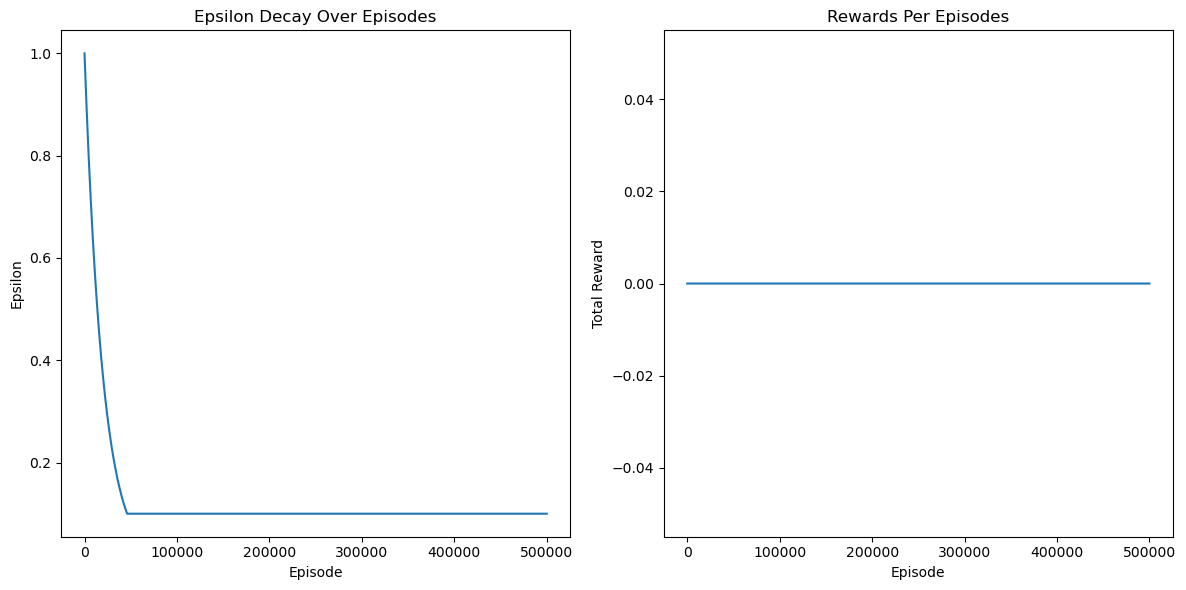

In [2]:
# plotting 10x10
plt.figure(figsize=(12, 6))

# epsilon decay
plt.subplot(1, 2, 1)
plt.plot(epsilon_values)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

# rewards per episode
plt.subplot(1, 2, 2)
plt.plot(reward_values)
plt.title('Rewards Per Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()

In [ ]:
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder='./video', episode_trigger=lambda x: True)

# exploitation episode to capture video
state , _= env.reset()
done = False
total_reward = 0
while not done:
    state_tensor = torch.tensor(np.identity(state_size)[state:state+1], dtype=torch.float32)
    action = choose_action(state_tensor, epsilon=0.1)  # exploit learned policy
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state

env.close()
print(f"Total Reward in test episode: {total_reward}")  

def display_video(video_path):
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data=f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>
        ''')
    
# get video
import os
from pathlib import Path

video_path = sorted(Path('./video').glob("*.mp4"), key=os.path.getmtime)[-1]
display_video(str(video_path))